In [1]:
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(0)
import random
import json
import pandas as pd
from datetime import datetime, timedelta

import pickle
import requests
from urllib.parse import urlencode
from sklearn.preprocessing import LabelEncoder
import json

# Visualisation
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
from plotnine import ggplot, aes, geom_bar, theme_minimal, labs

from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score



# Data load 

We load segment by segment

- I want to have a province for each user 
- Corrected times

In [194]:
# Long terms long time paying: 
# response_data = pd.read_csv('C:/Users/Win11/Downloads/20240320_081349_38157_zijzr.csv')

# Long term baby: 
lt_recent_payment_df = pd.read_csv('C:/Users/Win11/Downloads/20240320_081349_38157_zijzr.csv')
lt_recent_payment_df['matuirity_type'] = 'LT recent short pay history'
# Short term baby: 

st_1pay_df = pd.read_csv('C:/Users/Win11/Downloads/20240328_062840_11738_aakt7.csv')
st_gt_1pay_df = pd.read_csv('C:/Users/Win11/Downloads/20240328_062207_11282_aakt7.csv')
st_1pay_df['segments'] = 'Installed recently - one payment'
st_gt_1pay_df['segments'] = 'Installed recently - multiple payments'

df = pd.concat([st_1pay_df, st_gt_1pay_df], ignore_index=True)
df

,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,working_hours_payments_to_date,working_hours_bets_to_date,sleep_hours_bets_to_date,weekend_bets_to_date,withdrawn_attempt_to_date,withdrawn_attempted_ammount_to_date,minutes_to_withdraw_since_first_payment,past_disputer,new_disputer_30d,segments
0,10150296,2023-12-22 07:16:35.000,0,0,1.0,14,13.0,0,1,1,...,0,0.0,55.0,73.0,NaN,NaN,NaN,0,0,Installed recently - one payment
1,10150296,2023-12-22 07:16:35.000,1,1,1.0,14,13.0,1,1,1,...,0,0.0,55.0,73.0,NaN,NaN,NaN,0,0,Installed recently - one payment
2,10150296,2023-12-22 07:16:35.000,2,2,1.0,14,13.0,2,1,1,...,0,0.0,55.0,73.0,NaN,NaN,NaN,0,0,Installed recently - one payment
3,10150296,2023-12-22 07:16:35.000,3,3,1.0,14,13.0,3,1,1,...,0,0.0,55.0,73.0,NaN,NaN,NaN,0,0,Installed recently - one payment
4,10150296,2023-12-22 07:16:35.000,4,4,1.0,14,13.0,4,1,1,...,0,0.0,55.0,73.0,NaN,NaN,NaN,0,0,Installed recently - one payment
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
328312,10507720,2024-02-19 19:09:16.000,2,2,0.0,1,1.0,2,11,11,...,3,210.0,295.0,950.0,NaN,NaN,NaN,0,0,Installed recently - multiple payments
328313,10507720,2024-02-19 19:09:16.000,3,3,0.0,1,1.0,3,12,12,...,3,210.0,360.0,1249.0,NaN,NaN,NaN,0,0,Installed recently - multiple payments
328314,10507720,2024-02-19 19:09:16.000,4,4,0.0,1,1.0,4,14,14,...,3,210.0,493.0,1286.0,NaN,NaN,NaN,0,0,Installed recently - multiple payments
328315,10507720,2024-02-19 19:09:16.000,5,5,0.0,1,1.0,5,14,14,...,3,210.0,493.0,1286.0,NaN,NaN,NaN,0,0,Installed recently - multiple payments


In [23]:
# Alternative as a sample. Just check if the numbers are right 
# st_1pay_df = pd.read_csv('C:/Users/Win11/Downloads/20240328_062840_11738_aakt7.csv')
"C:\Users\Win11\Downloads\20240417_123012_75122_gs2bg.csv"
st_1pay_df = pd.read_csv('C:/Users/Win11/Downloads/20240415_123121_69908_hmxqd.csv')
st_gt_1pay_df = pd.read_csv('C:/Users/Win11/Downloads/20240415_123121_69908_hmxqd.csv')
st_1pay_df['segments'] = 'Short term'
st_gt_1pay_df['segments'] = 'Long term'

df = pd.concat([st_1pay_df, st_gt_1pay_df], ignore_index=True)
df


SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (1760544208.py, line 3)

In [ ]:
st_gt_1pay_df

,#account_id,register_time,matuirity_day,paying_matuirity,minutes_to_play,minutes_to_payment,minutes_to_pay_since_first_game,pay_matuirity,payments_to_date,payments_last_14d,...,sleep_hours_bets_to_date,weekend_bets_to_date,past_disputer,new_disputer_30d,local_time_before_6,local_time_6_to_12,local_time_12_to_18,local_time_after_18,province,segments
0,10089223,2023-12-11 00:31:42.000,9,7,54.0,3576,3522.0,7,1,1,...,193.0,251.0,0,0,0,0,1,0,MD,Long term
1,10089223,2023-12-11 00:31:42.000,10,8,54.0,3576,3522.0,8,1,1,...,193.0,251.0,0,0,0,0,1,0,NaN,Long term
2,10089223,2023-12-11 00:31:42.000,10,8,54.0,3576,3522.0,8,1,1,...,193.0,251.0,0,0,0,0,1,0,MD,Long term
3,10089223,2023-12-11 00:31:42.000,11,9,54.0,3576,3522.0,9,1,1,...,193.0,251.0,0,0,0,0,1,0,NaN,Long term
4,10089223,2023-12-11 00:31:42.000,11,9,54.0,3576,3522.0,9,1,1,...,193.0,251.0,0,0,0,0,1,0,MD,Long term
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344486,10491809,2024-02-17 02:08:07.000,19,19,0.0,12,12.0,19,1,0,...,374.0,412.0,0,0,0,1,0,0,ND,Long term
344487,10491809,2024-02-17 02:08:07.000,20,20,0.0,12,12.0,20,1,0,...,458.0,496.0,0,0,0,1,0,0,ND,Long term
344488,10491809,2024-02-17 02:08:07.000,21,21,0.0,12,12.0,21,1,0,...,461.0,499.0,0,0,0,1,0,0,ND,Long term
344489,10494145,2024-02-17 08:33:08.000,7,7,1.0,0,-1.0,7,1,1,...,194.0,194.0,0,0,0,0,1,0,VA,Long term


In [39]:
df.columns

Index(['#account_id', 'register_time', 'matuirity_day', 'paying_matuirity',
       'minutes_to_play', 'minutes_to_payment',
       'minutes_to_pay_since_first_game', 'pay_matuirity', 'payments_to_date',
       'payments_last_14d',
       ...
       'playing_days__[1,1,1,1,1,1,1,1,1,1,1]',
       'playing_days__[1,1,1,1,1,1,1,1,1,1]',
       'playing_days__[1,1,1,1,1,1,1,1,1]', 'playing_days__[1,1,1,1,1,1,1]',
       'playing_days__[1,1,1,1,1,1]', 'playing_days__[1,1,1,1,1]',
       'playing_days__[1,1,1,1]', 'playing_days__[1,1,1]',
       'playing_days__[1,1]', 'playing_days__[1]'],
      dtype='object', length=108)

In [3]:
midterm_1p    = pd.read_csv('C:/Users/Win11/Downloads/20240417_123012_75122_gs2bg.csv')
midterm_mult  = pd.read_csv('C:/Users/Win11/Downloads/20240418_005856_07589_gs2bg.csv')
longterm_mult = pd.read_csv('C:/Users/Win11/Downloads/20240418_020806_42680_gs2bg.csv')
longterm_1p   = pd.read_csv('C:/Users/Win11/Downloads/20240418_065604_04247_gs2bg.csv')
shortterm_all = pd.read_csv('C:/Users/Win11/Downloads/20240418_070628_04903_gs2bg.csv')

df = pd.concat([midterm_1p, midterm_mult, longterm_1p, longterm_mult, shortterm_all], ignore_index=True)

del midterm_1p    
del midterm_mult  
del longterm_mult 
del longterm_1p   
del shortterm_all 

# Define a function to assign segments based on the given factors
def assign_segment(row):
    if row['matuirity_day'] < 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day < 14 & payments > 1'
        else:
            return 'maturity_day < 14 & payments = 1'
    elif row['matuirity_day'] >= 14 and row['paying_matuirity'] < 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day > 14 & paying_matuirity < 14 & payments > 1'
        else:
            return 'maturity_day > 14 & paying_matuirity < 14 & payments = 1'
    elif row['matuirity_day'] >= 14 and row['paying_matuirity'] >= 14:
        if row['payments_to_date'] > 1:
            return 'maturity_day > 14 & paying_matuirity > 14 & payments > 1'
        else:
            return 'maturity_day > 14 & paying_matuirity > 14 & payments = 1'

# Apply the function to create the 'Segments' column
df['Segments'] = df.apply(assign_segment, axis=1)
df


### Analyse number of payments suitability 

You can do this for each group

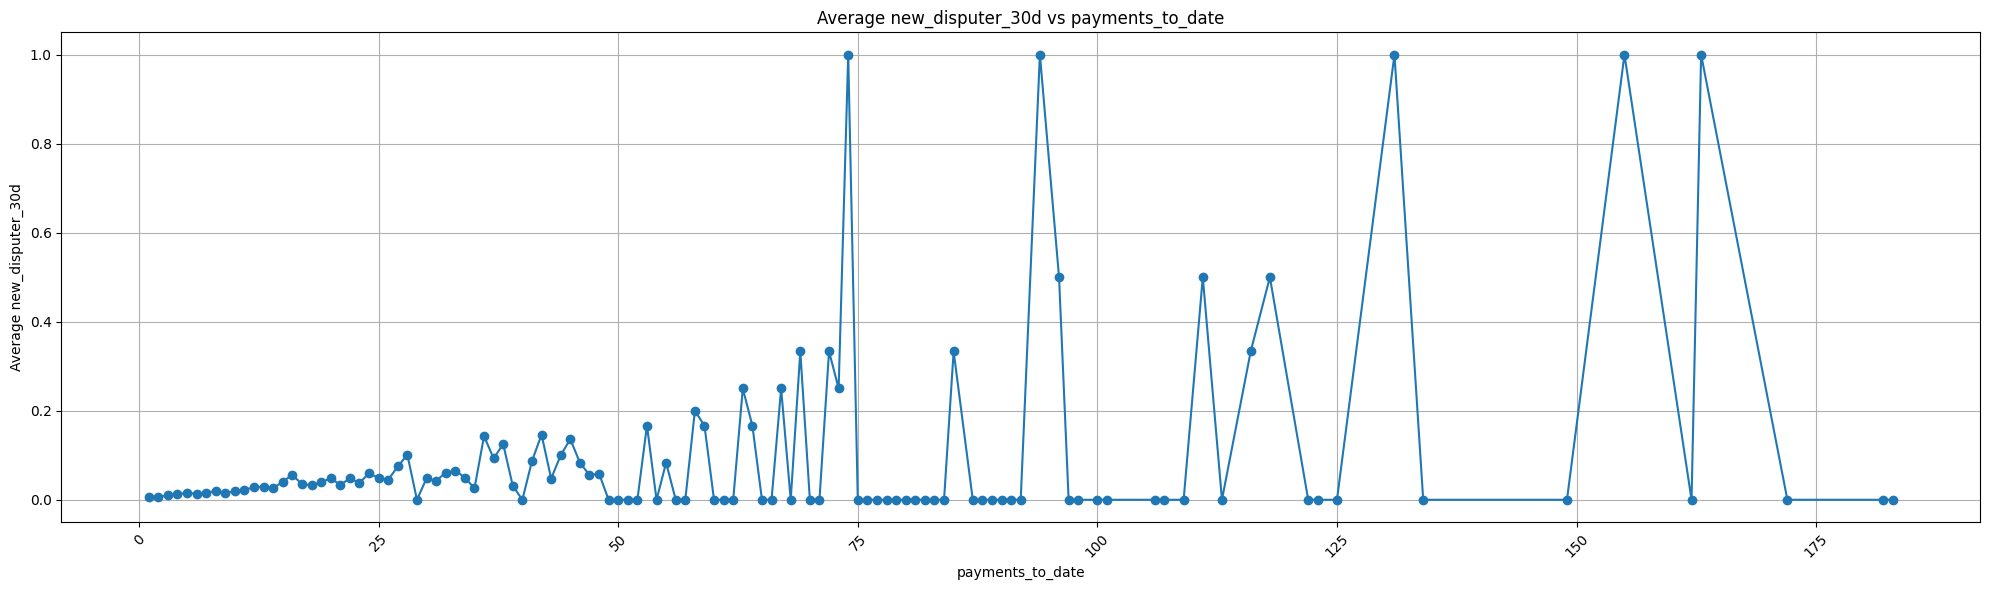

In [4]:
filtered_data = df[df['payments_to_date'] < 200]

# Grouping the data by 'payments_to_date' and calculating the mean of 'new_disputer_30d' for each group
average_disputer = filtered_data.groupby('payments_to_date')['new_disputer_30d'].mean()

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(average_disputer.index, average_disputer.values, marker='o', linestyle='-')
plt.title('Average new_disputer_30d vs payments_to_date')
plt.xlabel('payments_to_date')
plt.ylabel('Average new_disputer_30d')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


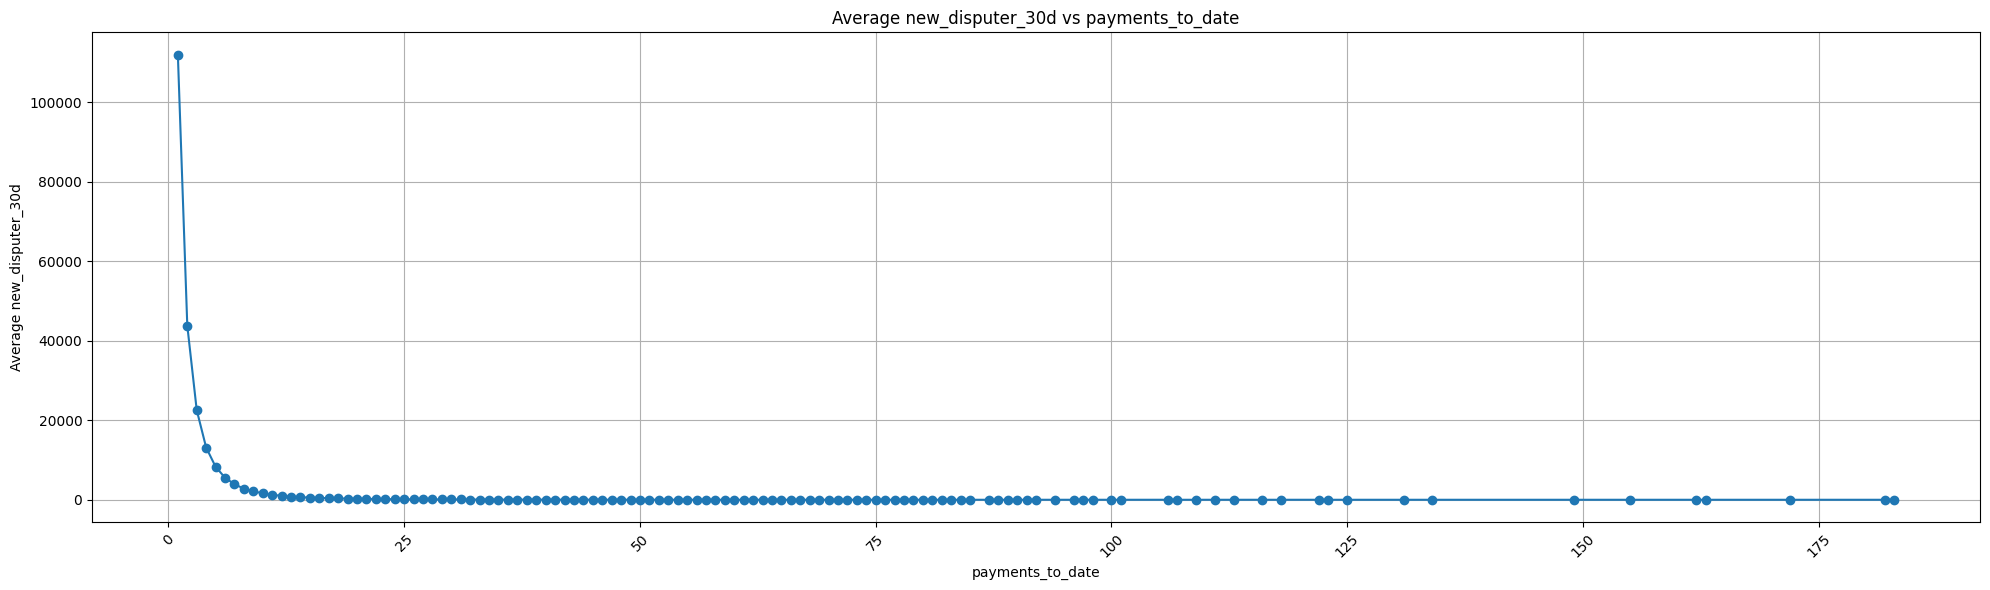

In [5]:
filtered_data = df[df['payments_to_date'] < 200]

# Grouping the filtered data by '

# Grouping the data by 'payments_to_date' and calculating the mean of 'new_disputer_30d' for each group
average_disputer = filtered_data.groupby('payments_to_date').size()

# Plotting
plt.figure(figsize = (20, 6))
plt.plot(average_disputer.index, average_disputer.values, marker = 'o', linestyle = '-')
plt.title('Average new_disputer_30d vs payments_to_date')
plt.xlabel('payments_to_date')
plt.ylabel('Average new_disputer_30d')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [6]:
num_groups = 3

# Calculate quantiles to split the data into approximately equal groups
quantiles = pd.qcut(df[df['payments_to_date'] > 1]['payments_to_date'], q=num_groups, labels=False, duplicates='drop')

# Add the quantiles as a new column to the DataFrame
df['quantile_group'] = quantiles + 1
df['payment_segment'] = df['quantile_group'].fillna(0)

group_counts = df.groupby('quantile_group')['payments_to_date'].max()
print(group_counts)


quantile_group
1.0      4
2.0    399
Name: payments_to_date, dtype: int64


**My decision for the first segment is 1, 2-5, 6+**

In [55]:
# df['segments'] = df['payment_segment'].astype(str) + ' - ' +  df['matuirity_type'].astype(str)
df['segments'].unique()

array(['Installed recently - one payment',
       'Installed recently - multiple payments'], dtype=object)


### Code for penalty-based rule

In [152]:
from sklearn.linear_model import LinearRegression

"""
I want a piece of code that runs a sequential regression, it runs 
"""

coefficients = {}

# You can apply just a linear regression and get the coefficients 
for group in df['segments'].unique(): 

    print(group)
    # Filter to the segment 
    train = df[df['segments'] == group]
    train['matuirity_day_adj'] =  pd.qcut(train['matuirity_day'], q=num_quantiles, labels=False, duplicates='drop')
    train['spent_to_date_adj'] =  pd.qcut(train['spent_to_date'], q=num_quantiles, labels=False, duplicates='drop')
    train['bet_money_to_date_adj'] =  pd.qcut(train['bet_money_to_date'], q=num_quantiles, labels=False, duplicates='drop')

    coefficients = {}

    for feature in ['matuirity_day_adj', 'spent_to_date_adj', 'bet_money_to_date_adj']:

        # Initialize Linear Regression model ()
        model = LinearRegression()
        y = train['new_disputer_30d']

        # Fit the model on the original data
        model.fit(train[[feature]].fillna(0), y)

        # Store the initial coefficients
        coefficients[f'{feature}_initial'] = model.coef_[0]

        # Calculate residuals
        residuals = y - model.predict(train[[feature]].fillna(0))

        # Train another model on the residuals
        model_residuals = LinearRegression()
        model_residuals.fit(train[[feature]].fillna(0), residuals)

        # Store the coefficients of the model trained on residuals
        # coefficients[f'{feature}_residuals'] = model_residuals.coef_[0]
    
    print(coefficients)
    

0.0 - New payer
{'matuirity_day_adj_initial': -4.915500824716905e-05, 'spent_to_date_adj_initial': 0.0017931345250978663, 'bet_money_to_date_adj_initial': 1.930781126647315e-06}
1.0 - New payer
{'matuirity_day_adj_initial': 0.00019169953467237726, 'spent_to_date_adj_initial': 0.00013646771239560486, 'bet_money_to_date_adj_initial': 1.226315764536564e-06}
2.0 - New payer
{'matuirity_day_adj_initial': 0.0002716505363020608, 'spent_to_date_adj_initial': -8.911800813360765e-05, 'bet_money_to_date_adj_initial': -5.7700692932048315e-05}
2.0 - nan
{'matuirity_day_adj_initial': -0.0022384830668649167, 'spent_to_date_adj_initial': 0.00020366408789016907, 'bet_money_to_date_adj_initial': 0.00010941307679872372}
1.0 - nan
{'matuirity_day_adj_initial': -0.0010508369136097103, 'spent_to_date_adj_initial': 0.00020086523633242362, 'bet_money_to_date_adj_initial': 1.820645615626979e-05}
0.0 - nan
{'matuirity_day_adj_initial': -0.0006846994414538496, 'spent_to_date_adj_initial': 0.0005823757868390175, 

# Opened box for short term analysis

In [8]:
st_payers['new_disputer_30d'].mean()
st_payers['new_disputer_30d'].mean()
st_payers[st_payers['paying_matuirity'] == 3]['new_disputer_30d'].mean()

0.008407815172613168

In [9]:
lt_recent_payment_df['new_disputer_30d'].mean()
lt_recent_payment_df['new_disputer_30d'].mean()
lt_recent_payment_df[lt_recent_payment_df['matuirity_day'] == 16]['new_disputer_30d'].mean()

0.005221932114882507

- So, the time since install does not impact much, what impacts is the time since payment. New installs pay more, so new users will generate most of the disputes. If they did not made the payment in the first day
- Other areas are also affected when we see that the impact of new users will decrease over time

In [10]:
lt_recent_payment_df['matuirity_day'].unique()

array([112,  41, 104,  18,  39,  82,  58,  60,  61,  16,  48,  24,  19,
        42,  86,  34,  21,  27,  20,  33,  28,  26,  80,  55,  56,  54,
        72,  25,  69,  30,  31,  23,  22,  17,  44,  35,  50,  51,  32,
        53,  36,  38,  52,  46,  29,  47,  37, 114, 105,  90,  74,  43,
        45,  49,  59, 106,  62,  76,  40,  66,  64,  67, 103,  57,  81,
       107,  94,  70,  71,  65, 121,  75,  77,  73,  97, 118,  96,  98,
        87,  68,  78,  84, 117,  63,  91,  85, 102,  79, 113, 109,  89,
       100,  93,  92,  83,  88, 108,  99, 116, 101,  95, 136], dtype=int64)

In [11]:

# The obejctive for the split is just that this payers are different from each other in a non-linear way (For me I can split 3-2, but 3-3 is also great). Overal payment fluctuations can be better understand 

# join but split the three segments 

# Then split by number of payers 

# Then you get the dispute rate 

# Then you correct it to matuirity and to payment matuirity. You also correct it to the number of payments (This is called the standarisation) - Econometric model


So, everything is about the time since payment. This is what matters. The only difference is the information that is available. 

You are also giving me problem with the payments, because different users will have different times after payment. This is the payment maturity and it is all that matters. 

So, what about this? You do the three and then on the last node you separate by matuirity 

In [11]:
st_payers

,#account_id,register_time,matuirity_day,paying_matuirity,time_to_payment,pay_matuirity,payments_to_date,payments_last_14d,payments_last_7d,spent_to_date,...,money_games_last_14d,money_games_last_7d,bet_money_to_date,bet_money_last_14d,bet_money_last_7d,win_amount_to_date,win_amount_last_14d,win_amount_last_7d,past_disputer,new_disputer_30d
0,10007525,2023-10-09 06:57:20.000,0,0,0,0,7,7,7,17.0,...,361.0,361.0,39.15,39.15,39.15,-17.90,-17.90,-17.90,0,0
1,10007525,2023-10-09 06:57:20.000,1,1,0,1,9,9,9,24.0,...,572.0,572.0,60.14,60.14,60.14,-26.65,-26.65,-26.65,0,0
2,10007525,2023-10-09 06:57:20.000,2,2,0,2,11,11,11,28.0,...,930.0,930.0,95.91,95.91,95.91,-29.65,-29.65,-29.65,0,0
3,10007525,2023-10-09 06:57:20.000,3,3,0,3,12,12,12,30.0,...,995.0,995.0,107.05,107.05,107.05,-33.65,-33.65,-33.65,0,0
4,10007525,2023-10-09 06:57:20.000,4,4,0,4,13,13,13,32.0,...,1006.0,1006.0,108.15,108.15,108.15,-34.45,-34.45,-34.45,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
218375,10499390,2024-02-18 04:38:07.000,0,0,0,0,1,1,1,20.0,...,255.0,255.0,124.40,124.40,124.40,151.30,151.30,151.30,0,0
218376,10499991,2024-02-18 06:08:00.000,0,0,0,0,2,2,2,7.0,...,201.0,201.0,177.50,177.50,177.50,153.64,153.64,153.64,0,0
218377,10500673,2024-02-18 08:42:25.000,0,0,0,0,1,1,1,20.0,...,182.0,182.0,71.10,71.10,71.10,40.56,40.56,40.56,0,0
218378,10501863,2024-02-18 17:27:34.000,0,0,0,0,3,3,3,10.0,...,211.0,211.0,44.99,44.99,44.99,25.55,25.55,25.55,0,0


In [12]:
result = st_payers[st_payers['payments_to_date'] == 1].copy(deep = True).fillna(0)
result['disputer'] =  result['new_disputer_30d']

# TS CV split
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
result.groupby('validation_set_id').size()

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [13]:
cols = ['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date'
        ,  'payments_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']

In [123]:

df.columns

Index(['#account_id', 'register_time', 'matuirity_day', 'paying_matuirity',
       'time_to_payment', 'pay_matuirity', 'payments_to_date',
       'payments_last_14d', 'payments_last_7d', 'spent_to_date',
       ...
       'pay__[1,1,0,0,0]', 'pay__[1,1,0,0]', 'pay__[1,1,0]',
       'pay__[1,1,1,1,1,1,1]', 'pay__[1,1,1,1,1,1]', 'pay__[1,1,1,1,1]',
       'pay__[1,1,1,1]', 'pay__[1,1,1]', 'pay__[1,1]', 'pay__[1]'],
      dtype='object', length=241)

In [15]:

model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [5]
leaf_sizes = [50]
payment_cols = cols + ['disputer']

# for train_index, test_index in splits:
for date_group in result['matuirity_day'].unique():
for date_group in [result['matuirity_day'].unique()]:

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['matuirity_day'] == date_group][payment_cols]
    train_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])



IndentationError: expected an indented block after 'for' statement on line 9 (1402966354.py, line 10)

# Okay so the code is very fast

- Decide the features (Or decide the tree structure even)
- Get the values of the trees and convert them into a dataframe
- Concatenate
- Then save it in dataframe format
- Then get all the data that you need and put it inside the machine


This is what I need to implement tomorrow. If you can have it accurately finished tomorrow that would be amazing. 

In [43]:
df.columns

Index(['#account_id', 'register_time', 'matuirity_day', 'paying_matuirity',
       'minutes_to_play', 'minutes_to_payment',
       'minutes_to_pay_since_first_game', 'pay_matuirity', 'payments_to_date',
       'payments_last_14d', 'payments_last_7d', 'payments_last_3d',
       'spent_to_date', 'spent_last_14d', 'spent_last_7d', 'spent_last_3d',
       'daily_spent_to_date', 'daily_spent_last_7_d', 'daily_spent_first_14d',
       'daily_spent_first_7d', 'daily_spent_first_1d', 'max_daily_spent',
       'max_payment', 'daily_payment_history_binary',
       'daily_payment_history_count', 'games_to_date', 'games_last_14d',
       'games_last_7d', 'max_games_daily_games', 'daily_games_first_14d',
       'daily_games_first_7d', 'daily_games_first_1d', 'retention_sequence',
       'games_sequence', 'days_betting_money_sequence',
       'days_50_usd_bet_money_sequence', 'money_games_to_date',
       'money_games_last_14d', 'money_games_last_7d', 'bet_money_to_date',
       'bet_money_last_14d'

Ask chatGPT, to undersand the code, and apply the converter to the tree obtained (You need to deal with  the feature selection). Althoug

In [45]:
cols = ['paying_matuirity', 'spent_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent'
        , 'max_payment', 'payments_last_14d', 'payments_last_7d',  'payments_to_date', 'daily_pay_std', 'minutes_to_payment', 'minutes_to_pay_since_first_game'
        , 'games_last_14d', 'games_last_7d', 'games_to_date', 'max_games_daily_games', 'daily_games_first_14d', 'daily_games_first_7d', 'daily_games_first_1d', 'minutes_to_play'
        , 'money_games_to_date', 'bet_money_to_date', 'max_bet',  'money_games_last_14d', 'money_games_last_7d'
        , 'win_amount_to_date',  'win_amount_last_14d', 'win_amount_last_7d'
        , 'working_hours_payments_to_date', 'working_hours_bets_to_date', 'sleep_hours_bets_to_date' 
        , 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date'
        # , 'province'
        , 'local_time_before_6', 'local_time_6_to_12', 'local_time_12_to_18', 'local_time_after_18']

columns_of_interest = ['retention_sequence', 'days_betting_money_sequence', 'days_50_usd_bet_money_sequence', 'daily_payment_history_binary']  # Add additional columns here if needed
columns_info = {'retention_sequence': 'playing_days_'
                # , 'money_bet_sequence': 'money_bet_'
                , 'daily_payment_history_binary': 'payer_'
                , 'daily_payment_history_count': 'pay_'
                , 'days_betting_money_sequence': 'days_bet_'
                , 'days_50_usd_bet_money_sequence': 'days_gt50_bet_'
                # , 'province': 'province_'
                }  # Add additional columns and identifiers here if needed


dummy_variable_list = []  # List to store dummy variables generated for each column

for column, identifier in columns_info.items():
    # Calculate sum of 'new_disputer_30d' for each unique value in the column
    sum_disputer = df.groupby(column)['new_disputer_30d'].sum()

    # Filter unique values where sum is >= 12
    valid_values = sum_disputer[sum_disputer >= 20].index.tolist()

    # Generate dummy variables for valid values
    dummy_variables = pd.get_dummies(df[column].loc[df[column].isin(valid_values)], prefix=identifier).astype(int)
    
    dummy_variable_list.append(dummy_variables)
    df = pd.concat([df, dummy_variables], axis=1)

# Concatenate all dummy variables into a single DataFrame
final_dummy_variables = pd.concat(dummy_variable_list, axis=1)

cols = cols + list(final_dummy_variables.columns)
final_dummy_variables.columns

In [33]:
print(df.columns)

Index(['#account_id', 'register_time', 'matuirity_day', 'paying_matuirity',
       'minutes_to_play', 'minutes_to_payment',
       'minutes_to_pay_since_first_game', 'pay_matuirity', 'payments_to_date',
       'payments_last_14d',
       ...
       'province__IN', 'province__MA', 'province__MO', 'province__NY',
       'province__OK', 'province__ON', 'province__PA', 'province__TN',
       'province__TX', 'province__WA'],
      dtype='object', length=151)


In [34]:
df['segments']

0          Short term
1          Short term
2          Short term
3          Short term
4          Short term
              ...    
1035459     Long term
1035460     Long term
1035461     Long term
1035462     Long term
1035463     Long term
Name: segments, Length: 1035464, dtype: object

In [35]:
items_to_remove = ['working_hours_bets_to_date', 'minutes_to_withdraw_since_first_payment', 'withdrawn_attempted_ammount_to_date', 'withdrawn_attempt_to_date', 'province']
cols = [item for item in cols if item not in items_to_remove]

In [36]:

# You can try to include matuirity as a penalty and see what approach works better 
from sklearn.tree import _tree
import pandas as pd
from tqdm import tqdm

# Define the model 
def create_model(criterion, depth, leaf_size):

    pipe = Pipeline([
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe

def traverse_tree(tree, node_id = 0, depth = 0, dataset = None, path = None):

    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Disputer rate"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Disputer rate": [proportion_true],
                                                    "Payers": [leaf_size], "Disputers": [true_cases]})], ignore_index=True)

    return dataset
    
high_level_dt = pd.DataFrame(columns = ["segments", "Event", "Disputer rate", "Payers", "Disputers"])  # Initiate an empty DataFrame to hold all datasets
model_results = []
all_model_results = []
criterion = 'log_loss'
depth = 5
leaf_size = 90
payment_cols = cols + ['new_disputer_30d']
segments = [1]

# Loop through segments
for segment in tqdm(df['segments'].unique()):

    # Get fraction of everything_df based on segment
    result = df[df['segments'] == segment].fillna(0)
    # print(segment)
    # print(result.shape[0])
    payment_cols = cols + list(final_dummy_variables.columns) + ['new_disputer_30d']
    # print(payment_cols)
    
    # Loop through matuirity days
    for maturity in result['matuirity_day'].unique(): 

        # Generate the Tree dataset and concatenate 
        train_data = result[result['matuirity_day'] == maturity][payment_cols]
        X_train, y_train = train_data.drop(columns = ['new_disputer_30d']), train_data['new_disputer_30d'] 

        # Train 
        clf = create_model(criterion, depth, leaf_size)
        clf.fit(X_train[cols], y_train)

        # Save the model into dictionary (Response, day, mo...)
        model_result = pd.DataFrame({
            'Matuirity': [maturity],
            'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)],
            'Model': [clf]
        })

        # Generate the dataset structure
        tree = clf[0].tree_
        # print(tree)
        dataset = traverse_tree(tree)

        # try: 
        #     dataset = traverse_tree(tree)
        # except: 
        #     print('ojo')
        event_columns = dataset['Event'].str.split(' & ', expand = True)
        dataset = pd.concat([dataset, event_columns], axis = 1)
        dataset.insert(0, "Matuirity", maturity + 1)
        dataset.insert(0, "Segment", segment)
        high_level_dt = pd.concat([high_level_dt, dataset], ignore_index = True)

# Sort and display the resulting DataFrame
high_level_dt.rename(columns={i: f"Condition {i + 1}" for i in range(5)}, inplace=True)
high_level_dt = high_level_dt[['Segment', 'Matuirity', 'Condition 1', 'Condition 2', 'Condition 3', 'Condition 4', 'Condition 5', 'Disputer rate', 'Payers', 'Disputers']].sort_values(by='Disputer rate', ascending=False).reset_index(drop = True)
# high_level_dt.drop_duplicates(inplace=False)

# Calculate the sum of True_Cases in the dataset
total_true_cases = high_level_dt['Disputers'].sum()
total_cases = high_level_dt['Payers'].sum()

# Calculate the percentage of True cases out of the total dataset sum for each row
high_level_dt['Payers_covered'] = (high_level_dt['Payers'] / total_cases).apply(lambda x: round(x, 3))
high_level_dt['Payers_covered_to_point'] = high_level_dt['Payers_covered'].cumsum().apply(lambda x: round(x, 3))
high_level_dt['Disputes_covered'] = (high_level_dt['Disputers'] / total_true_cases).apply(lambda x: round(x, 3))
high_level_dt['Disputes_covered_to_point'] = high_level_dt['Disputes_covered'].cumsum().apply(lambda x: round(x, 3))

high_level_dt.head(50)


100%|██████████| 2/2 [01:10<00:00, 35.34s/it]


,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers,Payers_covered,Payers_covered_to_point,Disputes_covered,Disputes_covered_to_point
0,Short term,8.0,max_daily_spent ≤ 95.0,sleep_hours_bets_to_date > 238.5,max_games_daily_games ≤ 231.5,daily_games_first_14d > 191.75,None,0.122222,90.0,11.0,0.0,0.0,0.006,0.006
1,Short term,17.0,max_daily_spent ≤ 95.0,local_time_after_18 > 0.5,daily_games_first_7d > 178.659,daily_games_first_1d ≤ 181.417,None,0.111111,90.0,10.0,0.0,0.0,0.006,0.012
2,Short term,9.0,spent_to_date ≤ 95.0,daily_games_first_14d > 175.917,daily_games_first_7d ≤ 176.071,daily_games_first_1d > 112.917,None,0.100000,160.0,16.0,0.0,0.0,0.009,0.021
3,Short term,13.0,spent_to_date ≤ 95.0,max_daily_spent > 9.995,money_games_last_14d ≤ 41.5,daily_games_first_14d > 179.75,games_last_14d ≤ 398.0,0.088889,90.0,8.0,0.0,0.0,0.005,0.026
4,Short term,12.0,max_payment ≤ 95.0,spent_to_date > 9.995,money_games_to_date ≤ 41.5,games_last_14d > 214.0,daily_games_first_1d ≤ 216.286,0.070866,127.0,9.0,0.0,0.0,0.005,0.031
5,Short term,14.0,daily_pay_std ≤ 25.39,spent_to_date > 9.995,money_games_last_14d ≤ 41.5,games_to_date > 214.0,sleep_hours_bets_to_date ≤ 416.5,0.070312,128.0,9.0,0.0,0.0,0.005,0.036
6,Short term,10.0,max_payment ≤ 95.0,sleep_hours_bets_to_date > 238.5,bet_money_to_date ≤ 5.625,win_amount_to_date > 0.805,None,0.067164,134.0,9.0,0.0,0.0,0.005,0.041
7,Short term,16.0,max_daily_spent ≤ 95.0,local_time_after_18 > 0.5,minutes_to_pay_since_first_game > 50.0,minutes_to_payment ≤ 175.5,None,0.066667,90.0,6.0,0.0,0.0,0.003,0.044
8,Long term,11.0,max_daily_spent ≤ 95.0,max_daily_spent > 9.995,bet_money_to_date ≤ 110.4,daily_games_first_14d > 175.75,daily_games_first_1d ≤ 178.45,0.066667,90.0,6.0,0.0,0.0,0.003,0.047
9,Short term,15.0,spent_to_date ≤ 95.0,money_games_last_14d ≤ 79.5,daily_games_first_1d > 131.25,daily_games_first_1d ≤ 144.1,max_daily_spent > 4.5,0.063380,142.0,9.0,0.0,0.0,0.005,0.052


In [179]:
high_level_dt

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Disputer rate,Payers,Disputers,Payers_covered,Payers_covered_to_point,Disputes_covered,Disputes_covered_to_point
0,Installed recently - one payment,2.0,spent_to_date > 247.485,bet_money_to_date > 14943.075,None,None,None,0.231884,69.0,16.0,0.000,0.000,0.006,0.006
1,Installed recently - multiple payments,2.0,spent_last_7d > 247.485,bet_money_to_date > 14943.075,None,None,None,0.231884,69.0,16.0,0.000,0.000,0.006,0.012
2,Installed recently - multiple payments,1.0,spent_to_date > 158.5,spent_last_7d > 849.995,None,None,None,0.212121,66.0,14.0,0.000,0.000,0.005,0.017
3,Installed recently - one payment,1.0,spent_last_14d > 158.5,spent_last_7d > 849.995,None,None,None,0.212121,66.0,14.0,0.000,0.000,0.005,0.022
4,Installed recently - multiple payments,3.0,max_daily_spent > 154.995,daily_pay_std > 136.724,minutes_to_play > 0.5,None,None,0.209677,62.0,13.0,0.000,0.000,0.005,0.027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269,Installed recently - one payment,4.0,spent_last_7d ≤ 288.995,max_daily_spent ≤ 11.995,max_daily_spent > 3.495,minutes_to_pay_since_first_game > 9.5,daily_pay_std > 2.565,0.000000,755.0,0.0,0.002,0.957,0.000,0.992
270,Installed recently - multiple payments,6.0,max_daily_spent ≤ 224.995,max_daily_spent ≤ 11.995,daily_pay_std > 1.717,win_amount_last_7d > -3.67,minutes_to_pay_since_first_game ≤ 61.5,0.000000,3139.0,0.0,0.009,0.966,0.000,0.992
271,Installed recently - one payment,4.0,spent_last_7d ≤ 288.995,max_daily_spent > 11.995,"days_gt50_bet__[1,0,1] > 0.5",max_payment > 29.995,daily_games_first_14d ≤ 345.5,0.000000,123.0,0.0,0.000,0.966,0.000,0.992
272,Installed recently - one payment,4.0,spent_last_7d > 288.995,max_payment ≤ 288.0,sleep_hours_bets_to_date ≤ 815.0,None,None,0.000000,114.0,0.0,0.000,0.966,0.000,0.992


In [104]:
high_level_dt.sort_values(by='Matuirity', ascending=False)['Condition 4'].unique()
high_level_dt.head(20)

,Segment,Matuirity,Condition 1,Condition 2,Condition 3,Condition 4,Condition 5,Proportion_True,Leaf_Size,True_Cases
148,Installed recently - multiple payments,2.0,spent_to_date > 247.485,max_daily_spent > 670.5,daily_pay_std ≤ 288.853,max_payment > 199.995,None,0.288889,45.0,13.0
126,Installed recently - multiple payments,1.0,spent_last_14d > 158.5,spent_to_date > 965.0,None,None,None,0.259259,54.0,14.0
101,Installed recently - one payment,1.0,spent_to_date > 70.0,games_to_date ≤ 46.0,None,None,None,0.244444,45.0,11.0
258,Installed recently - multiple payments,7.0,spent_last_7d > 267.995,spent_last_14d > 4157.495,daily_pay_std ≤ 188.489,None,None,0.222222,45.0,10.0
237,Installed recently - multiple payments,6.0,spent_to_date > 225.995,spent_to_date > 3599.995,daily_pay_std ≤ 202.582,None,None,0.222222,45.0,10.0
170,Installed recently - multiple payments,3.0,max_daily_spent > 154.995,daily_pay_std > 161.057,daily_pay_std ≤ 258.929,None,None,0.209677,62.0,13.0
192,Installed recently - multiple payments,4.0,spent_to_date > 288.995,max_payment > 288.0,spent_to_date ≤ 769.98,None,None,0.204082,49.0,10.0
195,Installed recently - multiple payments,4.0,spent_to_date > 288.995,max_payment > 288.0,spent_to_date > 769.98,spent_last_7d > 1781.99,games_last_14d > 7873.0,0.187500,48.0,9.0
218,Installed recently - multiple payments,5.0,spent_last_7d > 217.995,spent_last_7d > 3385.0,None,None,None,0.178571,84.0,15.0
233,Installed recently - multiple payments,6.0,spent_to_date > 225.995,spent_to_date ≤ 3599.995,money_games_to_date ≤ 10208.0,games_last_14d > 14838.5,None,0.177778,45.0,8.0


In [ ]:
"""
This is the Financial Plan: 

- I think regarding stock and investment is that all needs to go in. It does not matter if it is stocks or something else. 
- The second step it to manage risk and make decisions
- Evaluate make a living out of it. 

This is the ChatGPT request

Hello. For each group in matuirity date, 
"""

model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [4]
leaf_sizes = [50]
payment_cols = cols + ['disputer']

# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['matuirity_day'] == date_group][payment_cols]
    train_data =  result[result['matuirity_day'] == date_group][payment_cols]
    # train_data =  result[payment_cols]
    # test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

clf = all_model_results[all_model_results['Iteration'] == f'log_loss - {depth} - {leaf_size}'].sort_values()['Model'].values[0][0]


def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true],
                                                    "Leaf_Size": [leaf_size], "True_Cases": [true_cases]})], ignore_index=True)

    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)
event_columns = dataset['Event'].str.split(' & ', expand=True)
dataset = pd.concat([dataset, event_columns], axis=1)
# dataset = dataset[(dataset['True_Cases'] >= 10) | (dataset['Leaf_Size'] >= 100)]

dataset.sort_values(by = 'Proportion_True', ascending = False)
# dataset['Event'].values


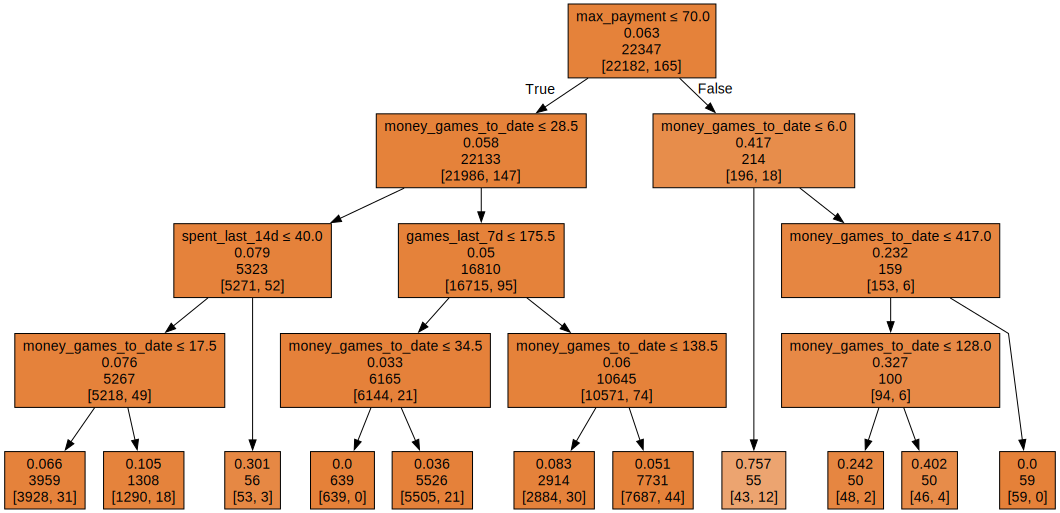

In [133]:
# Create the decision tree classifier
clf = all_model_results[all_model_results['Iteration'] == f'log_loss - {depth} - {leaf_size}']['Model'].values[0][0]

# from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = False
                           ,  rounded=False
                        #    ,  rotate = True
                           ,  special_characters=True)

graphviz.Source(dot_data)


In [134]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
    # if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]
        # proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true],
                                                    "Leaf_Size": [leaf_size], "True_Cases": [true_cases]})], ignore_index=True)

    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)
event_columns = dataset['Event'].str.split(' & ', expand=True)
dataset = pd.concat([dataset, event_columns], axis=1)
# dataset = dataset[(dataset['True_Cases'] >= 10) | (dataset['Leaf_Size'] >= 100)]

dataset.sort_values(by = 'Proportion_True', ascending = False)
# dataset['Event'].values

,Event,Proportion_True,Leaf_Size,True_Cases,0,1,2,3
7,max_payment > 70.0 & money_games_to_date ≤ 6.0,0.218182,55.0,12.0,max_payment > 70.0,money_games_to_date ≤ 6.0,None,None
9,max_payment > 70.0 & money_games_to_date > 6.0...,0.080000,50.0,4.0,max_payment > 70.0,money_games_to_date > 6.0,money_games_to_date ≤ 417.0,money_games_to_date > 128.0
2,max_payment ≤ 70.0 & money_games_to_date ≤ 28....,0.053571,56.0,3.0,max_payment ≤ 70.0,money_games_to_date ≤ 28.5,spent_last_14d > 40.0,None
8,max_payment > 70.0 & money_games_to_date > 6.0...,0.040000,50.0,2.0,max_payment > 70.0,money_games_to_date > 6.0,money_games_to_date ≤ 417.0,money_games_to_date ≤ 128.0
1,max_payment ≤ 70.0 & money_games_to_date ≤ 28....,0.013761,1308.0,18.0,max_payment ≤ 70.0,money_games_to_date ≤ 28.5,spent_last_14d ≤ 40.0,money_games_to_date > 17.5
5,max_payment ≤ 70.0 & money_games_to_date > 28....,0.010295,2914.0,30.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d > 175.5,money_games_to_date ≤ 138.5
0,max_payment ≤ 70.0 & money_games_to_date ≤ 28....,0.007830,3959.0,31.0,max_payment ≤ 70.0,money_games_to_date ≤ 28.5,spent_last_14d ≤ 40.0,money_games_to_date ≤ 17.5
6,max_payment ≤ 70.0 & money_games_to_date > 28....,0.005691,7731.0,44.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d > 175.5,money_games_to_date > 138.5
4,max_payment ≤ 70.0 & money_games_to_date > 28....,0.003800,5526.0,21.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d ≤ 175.5,money_games_to_date > 34.5
3,max_payment ≤ 70.0 & money_games_to_date > 28....,0.000000,639.0,0.0,max_payment ≤ 70.0,money_games_to_date > 28.5,games_last_7d ≤ 175.5,money_games_to_date ≤ 34.5


In [69]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def generate_rules_dataframe(tree, X, y_column):
    # Initialize lists to store rules and metrics
    rules = []
    proportion_true_list = []
    leaf_size_list = []
    true_cases_list = []

    # Extract rules and calculate metrics for each node
    def traverse_tree(node_id=0, current_rule=[]):
        # Convert current_rule to a string and append to the rules list
        rules.append(" & ".join(current_rule))

        # Apply the rule to filter the dataset
        if current_rule:
            filtered_data = X.query(" & ".join(current_rule))
            leaf_size = len(filtered_data)
            true_cases = filtered_data[y_column].sum()
            proportion_true = true_cases / leaf_size if leaf_size > 0 else 0
        else:
            # If current_rule is empty, set leaf size, true cases, and proportion true to 0
            leaf_size = 0
            true_cases = 0
            proportion_true = 0

        # Append metrics to the respective lists
        proportion_true_list.append(proportion_true)
        leaf_size_list.append(leaf_size)
        true_cases_list.append(true_cases)
        
        if tree.children_left[node_id] != _tree.TREE_LEAF:
            # Extract feature name and split value
            feature_name = X.columns[tree.feature[node_id]]
            split_value = tree.threshold[node_id]

            # Generate rules for the left child node
            left_rule = current_rule + [f"{feature_name} <= {round(split_value, 3)}"]
            traverse_tree(tree.children_left[node_id], left_rule)

            # Generate rules for the right child node
            right_rule = current_rule + [f"{feature_name} > {round(split_value, 3)}"]
            traverse_tree(tree.children_right[node_id], right_rule)

    traverse_tree()

    traverse_tree()

    # Create DataFrame from collected rules and metrics
    df = pd.DataFrame({
        'Event': rules,
        'Proportion_True': proportion_true_list,
        'Leaf_Size': leaf_size_list,
        'True_Cases': true_cases_list
    })

    return df

# Assuming 'clf' is the trained decision tree classifier and 'X_train' is the training dataset
tree = clf.tree_
X_train_rules = result[payment_cols].copy()  # Make a copy of the dataset to avoid modifying the original data
y_column = 'target_column_name'  # Update with the name of the target column
rules_df = generate_rules_dataframe(tree, X_train_rules, f'disputer')

event_columns = rules_df['Event'].str.split(' & ', expand=True)
rules_df = pd.concat([rules_df, event_columns], axis=1)
# dataset = dataset[(dataset['True_Cases'] >= 10) | (dataset['Leaf_Size'] >= 100)]

rules_df.drop_duplicates().fillna('').sort_values(by = [0,1,2,3,4,5], ascending = True).head(40)

# I want the tree to continue, until we reach the point where we are happy
# We are happy when: 100 sample size, or 10 true cases. 
# So, look at all the break downs and filter them out untill you reach the point where we have the condition met. What we are doing it to prune the tree after trainning to suit our condition. 


,Event,Proportion_True,Leaf_Size,True_Cases,0,1,2,3,4,5
0,,0.000000,0,0,,,,,,
1,spent_last_14d <= 322.0,0.005261,108536,571,spent_last_14d <= 322.0,,,,,
2,spent_last_14d <= 322.0 & games_last_7d <= 3.5,0.017382,2704,47,spent_last_14d <= 322.0,games_last_7d <= 3.5,,,,
3,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.013582,2577,35,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,,,
4,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.005862,853,5,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,,
5,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.014706,340,5,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d <= 1.5,
6,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.000000,252,0,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d <= 1.5,games_to_date <= 0.5
7,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.056818,88,5,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d <= 1.5,games_to_date > 0.5
8,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.000000,513,0,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date <= 2.495,games_last_7d > 1.5,
9,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.017401,1724,30,spent_last_14d <= 322.0,games_last_7d <= 3.5,spent_last_14d <= 35.0,spent_to_date > 2.495,,


In [99]:
def find_final_leaves(df):
    final_leaves = []
    
    # Helper function to recursively find final leaves
    def find_final_leaf(row):
        # If leaf size or true cases meet the condition, it's a final leaf
        if row['Leaf_Size'] >= 150 or row['True_Cases'] >= 10:
            final_leaves.append({'Event': row['Event'], 'Proportion_True': row['Proportion_True'],
                                 'Leaf_Size': row['Leaf_Size'], 'True_Cases': row['True_Cases'],
                                 'Node_Type': 'Leaf'})
        else:
            # Find child nodes and check if all are leaf nodes
            child_events = [child_row['Event'] for _, child_row in df.iterrows()
                            if child_row['Event'].startswith(row['Event']) and child_row['Event'] != row['Event']]
            all_child_leaves = all(event in final_leaves for event in child_events)
            
            if all_child_leaves:
                # If all child nodes are leaf nodes, it's a parent node
                final_leaves.append({'Event': row['Event'], 'Proportion_True': row['Proportion_True'],
                                     'Leaf_Size': row['Leaf_Size'], 'True_Cases': row['True_Cases'],
                                     'Node_Type': 'Parent'})
            else:
                # If any child node is not a leaf, it's a leaf node
                final_leaves.append({'Event': row['Event'], 'Proportion_True': row['Proportion_True'],
                                     'Leaf_Size': row['Leaf_Size'], 'True_Cases': row['True_Cases'],
                                     'Node_Type': 'Leaf'})

    # Iterate through each row to find final leaves
    for index, row in df.iterrows():
        if row['Leaf_Size'] == 0:  # Skip non-leaf nodes
            continue
        find_final_leaf(row)
    
    return pd.DataFrame(final_leaves)

# Find final leaves
final_leaves_df = find_final_leaves(rules_df)

def generate_node_ids(df):
    # Create a dictionary to store node IDs
    node_ids = {}
    current_id = 1
    
    # Helper function to recursively assign node IDs
    def assign_node_ids(row, parent_id=None):
        nonlocal current_id
        
        # Assign ID to current node
        node_ids[row['Event']] = current_id
        current_id += 1
        
        # Assign ID to children recursively
        child_events = [child_row['Event'] for _, child_row in df.iterrows()
                        if child_row['Event'].startswith(row['Event']) and child_row['Event'] != row['Event']]
        for child_event in child_events:
            assign_node_ids(df[df['Event'] == child_event].iloc[0], parent_id=node_ids[row['Event']])
    
    # Start assigning node IDs recursively
    root_event = df['Event'].iloc[0]
    assign_node_ids(df[df['Event'] == root_event].iloc[0])
    
    return node_ids

# Generate node IDs
node_ids = generate_node_ids(final_leaves_df)

# Add node ID column to final_leaves_df
final_leaves_df['Node_ID'] = final_leaves_df['Event'].map(node_ids)

# Check if children meet the condition
final_leaves_df['Children_Meet_Condition'] = final_leaves_df['Event'].apply(
    lambda x: any((child_row['Leaf_Size'] >= 150 or child_row['True_Cases'] >= 10)
                  for _, child_row in final_leaves_df.iterrows()
                  if child_row['Event'].startswith(x) and child_row['Event'] != x)
)

# Display final_leaves_df with Node_ID and Children_Meet_Condition columns
final_leaves_df.sort_values(by='Proportion_True', ascending=False).head(20)

# Reset index
final_leaves_df.reset_index(drop=True, inplace=True)

# Now, 'final_leaves_df' contains the final leaf nodes meeting the condition
final_leaves_df.sort_values(by='Proportion_True', ascending=False).head(20)


,Event,Proportion_True,Leaf_Size,True_Cases,Node_Type,Node_ID,Children_Meet_Condition
51,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
107,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
50,spent_last_14d > 322.0 & games_last_7d <= 30.5,0.545455,55,30,Leaf,NaN,True
106,spent_last_14d > 322.0 & games_last_7d <= 30.5,0.545455,55,30,Leaf,NaN,True
108,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
52,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
105,spent_last_14d > 322.0,0.286885,122,35,Leaf,NaN,True
49,spent_last_14d > 322.0,0.286885,122,35,Leaf,NaN,True
99,spent_last_14d <= 322.0 & games_last_7d > 3.5 ...,0.200000,30,6,Parent,4144.0,False
23,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.200000,25,5,Parent,3100.0,False


In [101]:
final_leaves_df[final_leaves_df['Children_Meet_Condition'] == False].sort_values(by='Proportion_True', ascending=False).head(20)

,Event,Proportion_True,Leaf_Size,True_Cases,Node_Type,Node_ID,Children_Meet_Condition
51,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
107,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.750000,20,15,Leaf,NaN,False
52,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
108,spent_last_14d > 322.0 & games_last_7d <= 30.5...,0.428571,35,15,Leaf,NaN,False
79,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.200000,25,5,Parent,3100.0,False
43,spent_last_14d <= 322.0 & games_last_7d > 3.5 ...,0.200000,30,6,Parent,4144.0,False
99,spent_last_14d <= 322.0 & games_last_7d > 3.5 ...,0.200000,30,6,Parent,4144.0,False
23,spent_last_14d <= 322.0 & games_last_7d <= 3.5...,0.200000,25,5,Parent,3100.0,False
110,spent_last_14d > 322.0 & games_last_7d > 30.5 ...,0.178571,28,5,Parent,NaN,False
54,spent_last_14d > 322.0 & games_last_7d > 30.5 ...,0.178571,28,5,Parent,NaN,False


In [92]:
final_leaves_df[final_leaves_df.index == 50]['Event'].values[0]

'spent_last_14d > 322.0 & games_last_7d <= 30.5'

In [33]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True", "Leaf_Size", "True_Cases"])
    
    if path is None:
        path = []

    if node_id != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        leaf_size = np.sum(tree.value[node_id])
        print(tree.value[node_id])
        true_cases = tree.value[node_id][0][1]  # Accessing the true cases correctly
        proportion_true = true_cases / leaf_size
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true],
                                                    "Leaf_Size": [leaf_size], "True_Cases": [true_cases]})], ignore_index=True)

    return dataset

# Convert DataFrame X_train to ndarray
X_train_array = X_train.values

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)
event_columns = dataset['Event'].str.split(' & ', expand=True)
dataset = pd.concat([dataset, event_columns], axis=1)

dataset.sort_values(by='Proportion_True', ascending=False)


[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]
[[39.  0.]]


,Event,Proportion_True,Leaf_Size,True_Cases,0,1,2,3,4,5,6
0,spent_last_14d ≤ 322.0 & games_last_7d ≤ 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d ≤ 3.5,spent_last_14d ≤ 35.0,spent_to_date ≤ 2.495,games_last_7d ≤ 1.5,games_to_date ≤ 0.5,daily_pay_std ≤ -2.0
43,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d > 6.5,games_to_date ≤ 1443.5,games_to_date > 1432.5,daily_pay_std > -2.0,None
31,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent ≤ 4.5,daily_pay_std > 0.697,money_games_to_date > 435.5,daily_pay_std > -2.0
32,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date ≤ 18.5,daily_pay_std ≤ -2.0,None
33,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date ≤ 18.5,daily_pay_std > -2.0,None
34,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date ≤ 19.5,daily_pay_std ≤ -2.0
35,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date ≤ 19.5,daily_pay_std > -2.0
36,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date > 19.5,daily_pay_std ≤ -2.0
37,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d ≤ 6.5,max_daily_spent > 4.5,money_games_to_date > 18.5,money_games_to_date > 19.5,daily_pay_std > -2.0
38,spent_last_14d ≤ 322.0 & games_last_7d > 3.5 &...,0.0,39.0,0.0,spent_last_14d ≤ 322.0,games_last_7d > 3.5,spent_last_14d > 6.5,games_to_date ≤ 1443.5,games_to_date ≤ 1432.5,spent_to_date ≤ 95.0,daily_pay_std ≤ -2.0


# Measure of performance

# Data manipulation

In [154]:
result = lt_recent_payment_df.copy(deep = True)
result['disputer'] =  result['new_disputer_30d']

In [155]:
# Generate a function that generates the log of a list of column names in a dataframe:
cols = ['spent_to_date', 'max_payment', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments']

column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'bet_money_last_7d', 'bet_money_last_14d', 'money_games_last_7d', 'money_games_last_14d', 'chip_games_last_14d']
def log_transform_columns(df, column_names):
    new_columns = []
    for col in column_names:
        new_col_name = f'l_{col}'
        df[new_col_name] = np.log(df[col])
        new_columns.append(new_col_name)
    return df, new_columns
result, logs_columns = log_transform_columns(result, column_names)
print(logs_columns)


# Generate a function that divides all the columns in a list by the columns in another list:
def divide_columns(df, dividend_columns, divisor_columns):
    new_columns = []
    for dividend_col, divisor_col in zip(dividend_columns, divisor_columns):
        new_col_name = f'ratio_{dividend_col}_to_{divisor_col}'
        df[new_col_name] = df[dividend_col] / df[divisor_col]
        new_columns.append(new_col_name)
    return df, new_columns

dividend_columns = ['spent_to_date']
divisor_columns = ['user_matuirity', 'payments_to_date']
result, ratios_columns_1 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_1)

dividend_columns = ['max_payment_in_day', 'max_payment']
divisor_columns = ['spent_to_date', 'payments_to_date']
result, ratios_columns_2 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_2)

dividend_columns = ['money_games_working_hours_last_14d']
divisor_columns = ['money_games_last_14d']
result, ratios_columns_3 = divide_columns(result,  dividend_columns, divisor_columns)
print(ratios_columns_3)

# Generate a function that generates all the multiplications between the columns in a dataframe
def generate_multiplications(df):
    new_columns = []
    columns = df.columns
    for i, col1 in enumerate(columns):
        for col2 in columns[i + 1:]:
            new_col_name = f'{col1}_x_{col2}'
            df[new_col_name] = df[col1] * df[col2]
            new_columns.append(new_col_name)
    return df, new_columns
# result, interacations_columns = generate_multiplications(result, column_names)


# Generate a function that generates k dummy variables in each column in list, where k is the number of quantiles - 1. The lowest quantile is left
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date', 'max_bet']
def generate_quantile_dummies(df, column_names, num_quantiles):
    new_columns = []
    for col in column_names:
        quantiles = df[col].quantile(np.linspace(0, 1, num_quantiles + 1)).reset_index(drop = True)
        for i in range(1, num_quantiles):
            new_col = f'{col}_quantile_{i}'
            df[new_col] = (df[col] > quantiles[i-1]).astype(int)
            new_columns.append(new_col)
    return df, new_columns
result, quantile_columns = generate_quantile_dummies(result, column_names, num_quantiles = 10)
print(quantile_columns)

# Generate a function that generates a dummy variable in each column in list, where 1 if the value is an outlier, and 0 otherwise.
column_names = ['spent_to_date', 'spent_last_7_days', 'payments_to_date']
def generate_outlier_dummies(df, column_names):
    new_columns = []
    for col in column_names:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        new_col_name = f'{col}_outlier'
        df[new_col_name] = ((df[col] < lower_bound) | (df[col] > upper_bound)).astype(int)
        new_columns.append(new_col_name)
    return df, new_columns
result, outlier_columns = generate_outlier_dummies(result, column_names)
print(outlier_columns)


KeyError: 'spent_last_7_days'

In [156]:
# cols = ['max_spent', 'daily_spent', 'spent_deviation', 'spent_ratio', 'time_to_payment', 'payments']
# cols = ['spent_to_date', 'payments_to_date', 'user_matuirity', 'payments_last_7_days', 'spent_last_7_days', 'max_payment_in_day', 'std_payments'] + logs_columns + ratios_columns_1 + ratios_columns_2 + ratios_columns_3 + quantile_columns + outlier_columns
cols = ['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date'
        ,  'payments_to_date', 'spent_last_14d',  'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']

print(cols)

print(len(result[cols].columns))
# time_pay_to_dispute	time_to_dispute	payments_to_date	payments_last_7_days	spent_last_7_days	spent_to_date	max_payment	max_payment_in_day	std_payments	disputer_lt_30d
result = result.replace([np.inf, -np.inf, np.nan], 0)
print(len(result[cols].columns))

result.loc[:, (result != result.iloc[0]).any()]
len(result[cols].columns)


['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date', 'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']
13
13


13

# Exploration of overfit and explanainable model

In [157]:

def create_model(criterion, depth, leaf_size):

    # preprocessor = ColumnTransformer(
    #     transformers = [
    #         ('scaler', StandardScaler(), cols)
    #     ],
    #     remainder='passthrough'
    # )

    # Create the pipeline
    pipe = Pipeline([
        # ('preprocessor', preprocessor),
        ('regressor', DecisionTreeClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
        # ('regressor', RandomForestClassifier(criterion = criterion, max_depth = depth, min_samples_leaf = leaf_size))
    ])

    return pipe


In [158]:
validation_sets = 3
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
result.groupby('validation_set_id').size()

validation_set_id
(20231001.999, 20231210.0]    1969
(20231210.0, 20231230.0]      1891
(20231230.0, 20240202.0]      1838
dtype: int64

In [186]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score

model_results = []
all_model_results = []
criteria = ['log_loss']
depths = [5]
leaf_sizes = [50]
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    # train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[result['validation_set_id'] == date_group][payment_cols]
    train_data =  result[payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])

100%|██████████| 1/1 [00:00<00:00, 20.05it/s]


In [187]:
# all_model_results.groupby(['Iteration', 'Test at', 'Model']).mean()
amrgb = all_model_results.groupby('Iteration')[['accuracy', 'precission']].mean().sort_values(by = 'accuracy', ascending = False).reset_index(drop = False)
amrgb

,Iteration,accuracy,precission
0,log_loss - 5 - 50,0.995511,0.0


In [189]:
# all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0]
all_model_results[all_model_results['Iteration'] == 'log_loss - 6 - 50']['Model'].values[0]

IndexError: index 0 is out of bounds for axis 0 with size 0

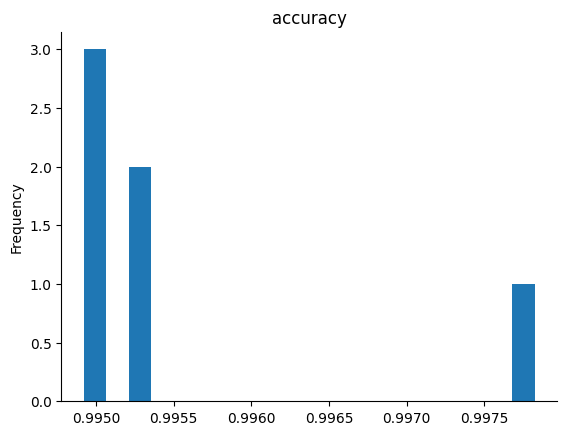

In [162]:
# @title accuracy

from matplotlib import pyplot as plt
all_model_results['accuracy'].plot(kind='hist', bins=20, title='accuracy')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [163]:
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 4 - 100']['Model'].values[0]
payment_cols
train_data.columns

Index(['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d',
       'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date',
       'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std',
       'money_games_to_date', 'disputer'],
      dtype='object')

In [164]:
train_data.columns
train_data['Predicted_Probability_A'] = clf.predict_proba(train_data[cols])[:, 1]  # Probability of class 1
train_data['True_Label'] = train_data[f'disputer']

import plotly.graph_objects as go

# Initialize lists to store results
thresholds = np.linspace(0, 0.9, 100)  # Thresholds from 0 to 30%
bad_users = []
correct_bad_users = []

# Iterate through thresholds
for threshold in thresholds:
    # Classify users as "bad" if their probability is above the threshold
    classified_as_bad = train_data['Predicted_Probability_A'] > threshold
    
    # Count the total number of users classified as "bad"
    total_bad = np.sum(classified_as_bad)
    
    # Count the number of correctly classified "bad" users
    correctly_classified_bad = np.sum(classified_as_bad & (train_data['True_Label'] == 1))
    
    # Append results to lists
    bad_users.append(total_bad)
    correct_bad_users.append(correctly_classified_bad)

# Convert total bad users to percentage
total_users = len(train_data)
bad_users_percentage = [bad / total_users * 100 for bad in bad_users]

# Plot the results using Plotly with a bigger figure size
fig = go.Figure()
fig.add_trace(go.Scatter(x=thresholds, y=bad_users_percentage, mode='lines', name='Total Bad Users (%)'))
fig.add_trace(go.Scatter(x=thresholds, y=correct_bad_users, mode='lines', name='Correctly Classified Bad Users'))
fig.update_layout(title='Number of Users vs Threshold', xaxis_title='Threshold', yaxis_title='Number of Users', legend=dict(x=0, y=1), width=2000, height=1000)
fig.show()

In [165]:
def calculate_percentage(df, threshold):
    """
    Calculate the percentage of observations with a probability greater than or equal to the threshold
    and the percentage of cases above the threshold that are actually true (1), out of all the true cases.
    
    Args:
    - df (DataFrame): DataFrame containing actual observations and predicted probabilities.
                      It should have columns 'Predicted_Probability' and 'True_Label'.
    - threshold (float): Threshold value for classification.
    
    Returns:
    - percent_above_threshold (float): Percentage of observations with a probability greater than or equal to the threshold.
    - percent_true_above_threshold (float): Percentage of cases above the threshold that are actually true (1),
                                             out of all the true cases.
    """
    # Filter rows where predicted probability is greater than or equal to the threshold
    above_threshold = df['Predicted_Probability'] >= threshold
    
    # Calculate percentage of observations above the threshold
    percent_above_threshold = (above_threshold.sum() / len(df)) * 100
    
    # Filter rows where predicted probability is above the threshold and true label is 1
    true_above_threshold = df.loc[above_threshold, 'True_Label'] == 1
    
    # Calculate percentage of true cases above the threshold out of all true cases
    if df['True_Label'].sum() > 0:
        percent_true_above_threshold = (true_above_threshold.sum() / df['True_Label'].sum()) * 100
    else:
        percent_true_above_threshold = 0  # Handle case where there are no true cases
    
    return percent_above_threshold, percent_true_above_threshold

train_data.columns
train_data['Predicted_Probability'] = clf.predict_proba(train_data[cols])[:, 1]  # Probability of class 1
train_data['True_Label'] = train_data[f'disputer']

In [166]:
# Assuming you have already calculated 'Predicted_Probability_A' and 'True_Label' columns in your DataFrame 'train_data'

# Set the threshold value
threshold = 0.024 # Adjust as needed

# Apply the function to calculate percentages
percent_above_threshold, percent_true_above_threshold = calculate_percentage(train_data, threshold)

# Print the results
print("Percentage of observations with probability greater than or equal to the threshold:", percent_above_threshold)
print("Percentage of true cases above the threshold out of all true cases:", percent_true_above_threshold)


Percentage of observations with probability greater than or equal to the threshold: 4.15935415935416
Percentage of true cases above the threshold out of all true cases: 39.130434782608695


[0.   0.02 0.04 0.06 0.08 0.1  0.12 0.14 0.16 0.18 0.2  0.22 0.24 0.26
 0.28 0.3  0.32 0.34 0.36 0.38 0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54
 0.56 0.58 0.6  0.62 0.64 0.66 0.68 0.7  0.72 0.74 0.76 0.78 0.8  0.82
 0.84 0.86 0.88 0.9  0.92 0.94 0.96 0.98 1.  ]


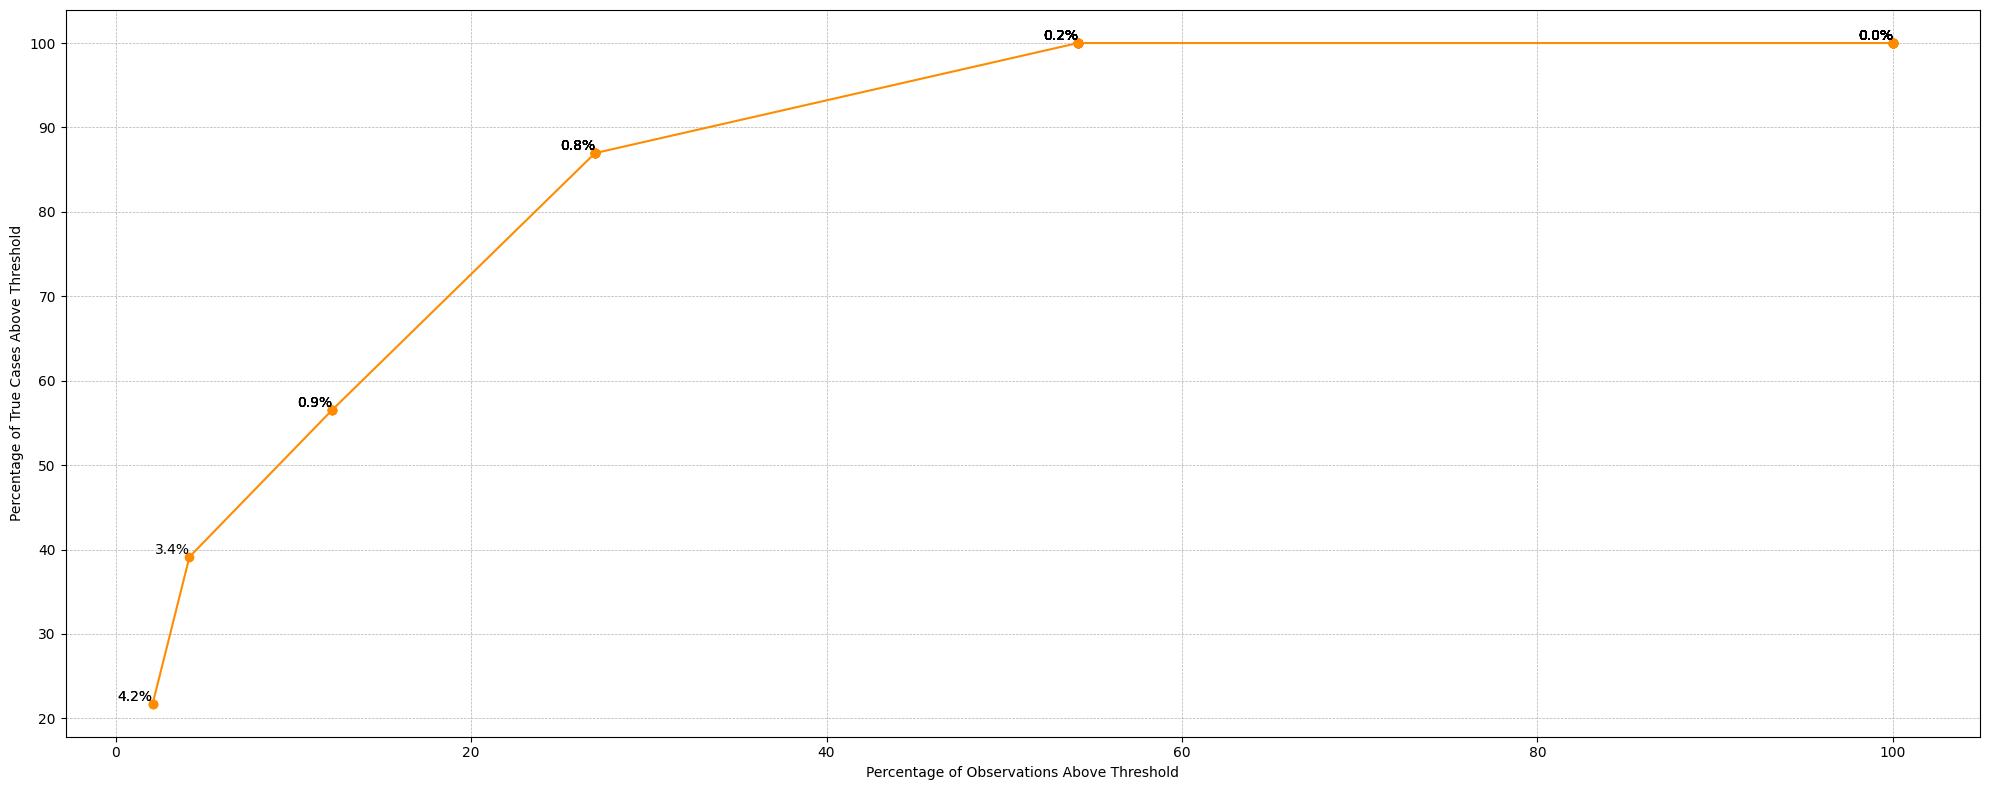

In [167]:
quantiles = np.linspace(0, 1, 51)  # Divide the range [0, 1] into 10 quantiles
print(quantiles)
# Initialize lists to store results
percent_above_thresholds = []
percent_true_above_thresholds = []
quantile_values = []

# Iterate through quantiles
for quantile in quantiles:
    threshold = train_data['Predicted_Probability'].quantile(quantile)
    percent_above_threshold, percent_true_above_threshold = calculate_percentage(train_data, threshold)
    percent_above_thresholds.append(percent_above_threshold)
    percent_true_above_thresholds.append(percent_true_above_threshold)
    quantile_values.append(threshold)

# Plot the results
plt.figure(figsize=(20, 8))
plt.plot(percent_above_thresholds, percent_true_above_thresholds, marker='o', color='darkorange', linestyle='-')
for i, txt in enumerate(quantile_values):
    plt.annotate(f'{txt*100:.1f}%', (percent_above_thresholds[i], percent_true_above_thresholds[i]), fontsize=10, ha='right', va='bottom')
plt.xlabel('Percentage of Observations Above Threshold')
plt.ylabel('Percentage of True Cases Above Threshold')
# plt.title('Percentage of True Cases vs Percentage of Observations Above Threshold')
plt.title('')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

In [168]:

# Rule identifier 
node_size = 0.02
found = (0.10 * node_size) 
total = 0.01

impact_dispute_rate = found / total
impact_users = total 

print(impact_dispute_rate, impact_users)

0.2 0.01


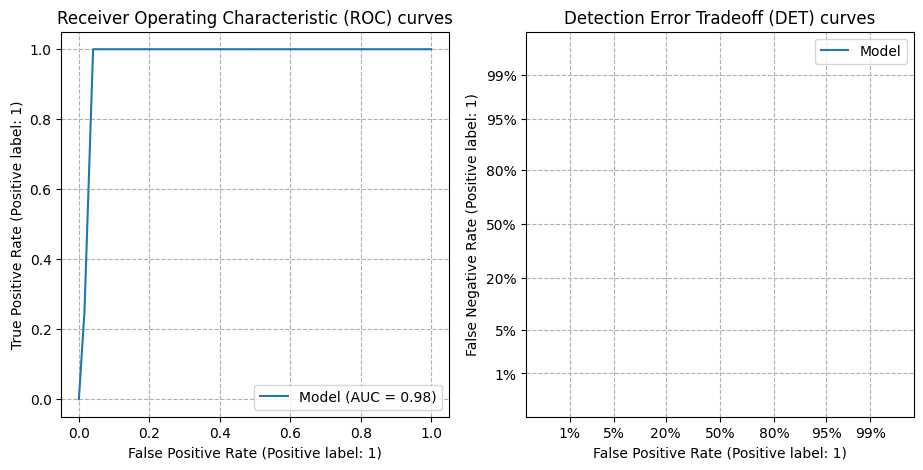

In [169]:

import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

# for name, clf in classifiers.items():
#     clf.fit(X_train, y_train)

RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name='Model')
DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name='Model')

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

['spent_to_date', 'max_payment', 'payments_last_14d', 'payments_last_7d', 'games_last_14d', 'games_last_7d', 'games_to_date', 'payments_to_date', 'spent_last_14d', 'spent_last_7d', 'max_daily_spent', 'daily_pay_std', 'money_games_to_date']


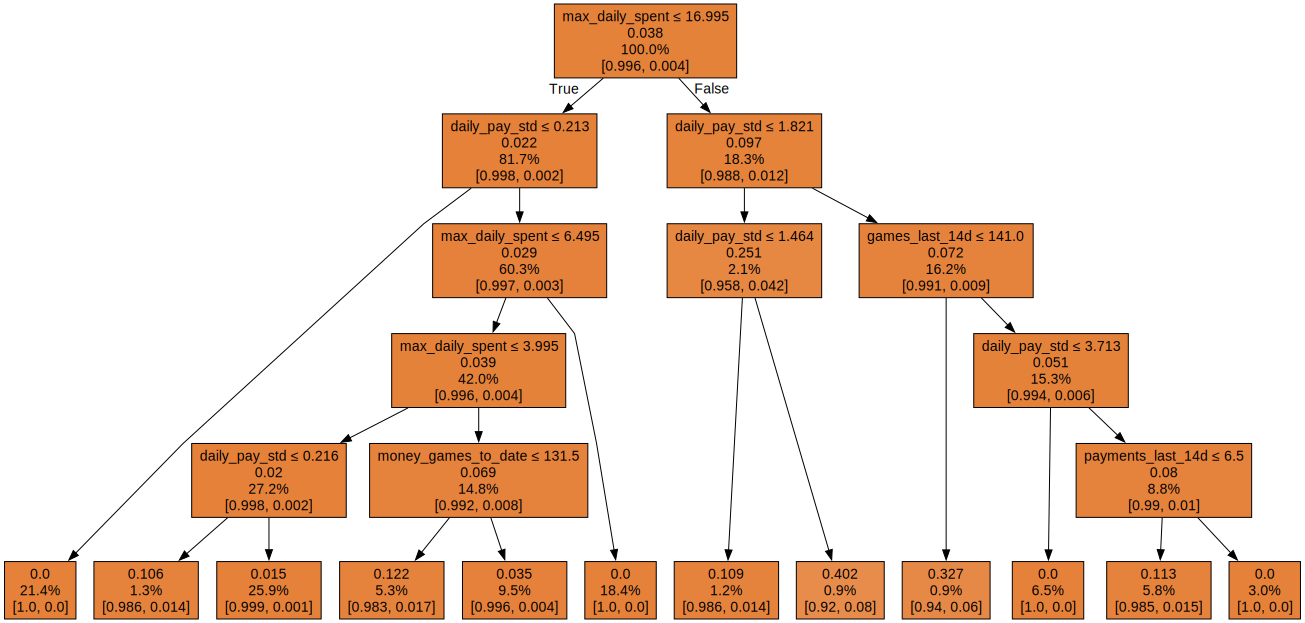

In [190]:
# from sklearn import tree
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files/Graphviz/bin'  # Adjust the path as per your Graphviz installation

from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 350']['Model'].values[0][0]
# clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 70']['Model'].values[0][0]
clf = all_model_results[all_model_results['Iteration'] == 'log_loss - 5 - 50']['Model'].values[0][0]

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

print(cols)
# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled=True
                           ,  leaves_parallel = True
                           ,  proportion = True
                           ,  rounded=False
                        #    ,  rotate = True
                           ,  special_characters=True)

graphviz.Source(dot_data)
# print(dot_data)



In [230]:
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=[f"Breakdown_{depth + 1}", f"Proportion_{depth + 1}"])
    
    if tree.children_left[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        breakdown_left = f"{feature_name} ≤ {round(split_value, 3)}"
        proportion_left = 1 - (tree.value[node_id][0][y_train[node_id]] / np.sum(tree.value[node_id]))
        dataset.at[node_id, f"Breakdown_{depth + 1}"] = breakdown_left
        dataset.at[node_id, f"Proportion_{depth + 1}"] = proportion_left
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset)
        
    if tree.children_right[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        breakdown_right = f"{feature_name} > {split_value}"
        proportion_right = 1 - (tree.value[node_id][0][y_train[node_id]] / np.sum(tree.value[node_id]))
        dataset.at[node_id, f"Breakdown_{depth + 2}"] = breakdown_right
        dataset.at[node_id, f"Proportion_{depth + 2}"] = proportion_right
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset)
    
    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)

dataset




,Breakdown_1,Proportion_1,Breakdown_2,Proportion_2,Breakdown_3,Proportion_3,Breakdown_4,Proportion_4,Breakdown_5,Proportion_5,Breakdown_6,Proportion_6
0,max_daily_spent ≤ 16.995,0.004037,max_daily_spent > 16.994999885559082,0.004037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,daily_pay_std ≤ 0.213,0.002148,daily_pay_std > 0.21260014921426773,0.002148,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,max_daily_spent ≤ 6.495,0.002909,max_daily_spent > 6.494999885559082,0.002909,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,max_daily_spent ≤ 3.995,0.004182,max_daily_spent > 3.9950000047683716,0.004182,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,daily_pay_std ≤ 0.216,0.001938,daily_pay_std > 0.21570930629968643,0.001938
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,money_games_to_date ≤ 131.5,0.008304,money_games_to_date > 131.5,0.008304
12,NaN,NaN,daily_pay_std ≤ 1.821,0.012464,daily_pay_std > 1.8213537335395813,0.012464,NaN,NaN,NaN,NaN,NaN,NaN
13,NaN,NaN,NaN,NaN,daily_pay_std ≤ 1.464,0.042017,daily_pay_std > 1.4639541506767273,0.042017,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,games_last_14d ≤ 141.0,0.008658,games_last_14d > 141.0,0.008658,NaN,NaN,NaN,NaN
18,NaN,NaN,NaN,NaN,NaN,NaN,daily_pay_std ≤ 3.713,0.005721,daily_pay_std > 3.7133249044418335,0.005721,NaN,NaN


In [234]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} ≤ {round(split_value, 3)}", False)]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} > {round(split_value, 3)}", True)]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        event = " AND ".join([f"{event_name} is {is_true}" for event_name, is_true in path])
        new_row = pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true]})
        dataset = pd.concat([dataset, new_row], ignore_index=True)
    
    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)

dataset.sort_values(by = 'Proportion_True', ascending = False)
dataset['Event'].values

array(['max_daily_spent ≤ 16.995 is False AND daily_pay_std ≤ 0.213 is False',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent ≤ 3.995 is False AND daily_pay_std ≤ 0.216 is False',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent ≤ 3.995 is False AND daily_pay_std > 0.216 is True',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent > 3.995 is True AND money_games_to_date ≤ 131.5 is False',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent ≤ 6.495 is False AND max_daily_spent > 3.995 is True AND money_games_to_date > 131.5 is True',
       'max_daily_spent ≤ 16.995 is False AND daily_pay_std > 0.213 is True AND max_daily_spent > 6.495 is True',
       'max_daily_spent > 16.995 is True AND daily_

In [238]:
import pandas as pd
import numpy as np
from sklearn.tree import _tree

def traverse_tree(tree, node_id=0, depth=0, dataset=None, path=None):
    if dataset is None:
        dataset = pd.DataFrame(columns=["Event", "Proportion_True"])
    
    if path is None:
        path = []

    if tree.children_left[node_id] != _tree.TREE_LEAF:
        feature_name = X_train.columns[tree.feature[node_id]]
        split_value = tree.threshold[node_id]
        
        path_left = path + [(f"{feature_name} > {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_left[node_id], depth + 1, dataset, path_left)
        
        path_right = path + [(f"{feature_name} ≤ {round(split_value, 3)}")]
        dataset = traverse_tree(tree, tree.children_right[node_id], depth + 1, dataset, path_right)
        
    else:
        proportion_true = tree.value[node_id][0][1] / np.sum(tree.value[node_id])
        event = " & ".join([f"{event_name}" if " > " in event_name else f"{event_name}" for event_name in path])
        dataset = pd.concat([dataset, pd.DataFrame({"Event": [event], "Proportion_True": [proportion_true]})], ignore_index=True)
    
    return dataset

# Generate the dataset structure
tree = clf.tree_
dataset = traverse_tree(tree)

dataset
dataset['Event'].values

array(['max_daily_spent > 16.995 & daily_pay_std > 0.213',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent > 3.995 & daily_pay_std > 0.216',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent > 3.995 & daily_pay_std ≤ 0.216',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent ≤ 3.995 & money_games_to_date > 131.5',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent > 6.495 & max_daily_spent ≤ 3.995 & money_games_to_date ≤ 131.5',
       'max_daily_spent > 16.995 & daily_pay_std ≤ 0.213 & max_daily_spent ≤ 6.495',
       'max_daily_spent ≤ 16.995 & daily_pay_std > 1.821 & daily_pay_std > 1.464',
       'max_daily_spent ≤ 16.995 & daily_pay_std > 1.821 & daily_pay_std ≤ 1.464',
       'max_daily_spent ≤ 16.995 & daily_pay_std ≤ 1.821 & games_last_14d > 141.0',
       'max_daily_spent ≤ 16.995 & daily_pay_std ≤ 1.8

In [223]:
# Merge breakdown columns into one unified column
breakdown_cols = [col for col in dataset.columns if col.startswith("Breakdown")]
dataset["Breakdown"] = dataset[breakdown_cols].apply(lambda row: ", ".join(row.dropna()), axis=1)

# Create a single "Proportion" column
proportion_cols = [col for col in dataset.columns if col.startswith("Proportion")]
dataset["Proportion"] = dataset[proportion_cols].fillna(0).max(axis=1)

# Drop the original breakdown and proportion columns
dataset = dataset.drop(columns=breakdown_cols + proportion_cols)

# Sort the dataframe by the "Proportion" column
dataset = dataset.sort_values(by="Proportion", ascending=False).reset_index(drop = True)

In [226]:
dataset[dataset.index == 0]['Breakdown'][0]

'daily_pay_std ≤ 1.464, daily_pay_std > 1.4639541506767273'

In [227]:
dataset

,Breakdown,Proportion
0,"daily_pay_std ≤ 1.464, daily_pay_std > 1.46395...",0.042017
1,"daily_pay_std ≤ 1.821, daily_pay_std > 1.82135...",0.012464
2,"payments_last_14d ≤ 6.5, payments_last_14d > 6.5",0.009940
3,"games_last_14d ≤ 141.0, games_last_14d > 141.0",0.008658
4,"money_games_to_date ≤ 131.5, money_games_to_da...",0.008304
5,"daily_pay_std ≤ 3.713, daily_pay_std > 3.71332...",0.005721
6,"max_daily_spent ≤ 3.995, max_daily_spent > 3.9...",0.004182
7,"max_daily_spent ≤ 16.995, max_daily_spent > 16...",0.004037
8,"max_daily_spent ≤ 6.495, max_daily_spent > 6.4...",0.002909
9,"daily_pay_std ≤ 0.213, daily_pay_std > 0.21260...",0.002148


If approapiate you can rebalance the number of users

In [25]:
# response_data[response_data['daily_spent'] >= 53.274][response_data['spent_deviation'] <= 4.622].head(20)
# response_data[response_data['daily_spent'] >= 53.274][response_data['payments'] <= 7.5].head(20)
# response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5].head(20)
# # response_data[response_data['daily_spent'] > 18.215][response_data['payments'] <= 3.5]

The conclusion is that the model looks for high payers, and it barely cares about withdrawal patterns.

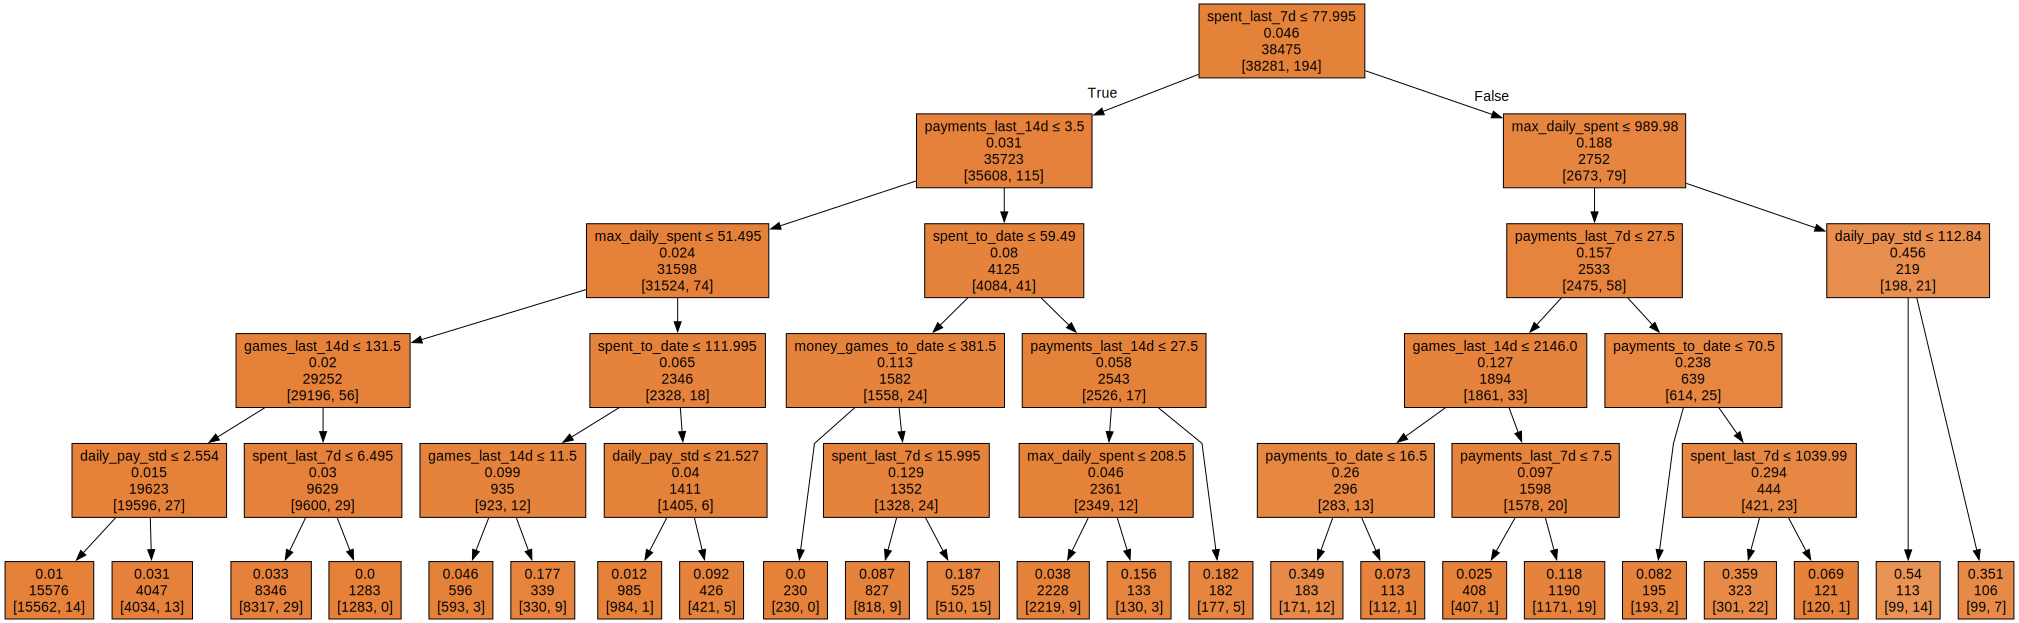

In [46]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

# Create the decision tree classifier

# Train the classifier with your data

# Assuming you have your data stored in X_train and y_train
# clf.fit(X_train, y_train)

# Visualize the decision tree
dot_data = export_graphviz(clf,
                           out_file = None
                           ,  feature_names = cols
                          #  ,  class_names=True
                           ,  label = 'none'
                           ,  filled = True
                           ,  leaves_parallel = True
                          #  ,  proportion = True
                           ,  rounded = False
                           ,  special_characters = True)

graphviz.Source(dot_data)



# Real model selection

In [47]:
validation_sets = 3
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()


validation_set_id
(20231001.999, 20231216.0]    13491
(20231216.0, 20240104.0]      12199
(20240104.0, 20240122.0]      12785
dtype: int64

In [48]:
result['validation_set_id'].unique()

[(20231001.999, 20231216.0], (20231216.0, 20240104.0], (20240104.0, 20240122.0]]
Categories (3, interval[float64, right]): [(20231001.999, 20231216.0] < (20231216.0, 20240104.0] < (20240104.0, 20240122.0]]

In [49]:

train_data =  result[result['validation_set_id'] != result['validation_set_id'].unique()[2]][payment_cols]
test_data =  result[result['validation_set_id'] == result['validation_set_id'].unique()[2]][payment_cols]

X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

# X_train.sample(5)
X_test.sample(5)

,spent_to_date,max_payment,payments_last_14d,payments_last_7d,games_last_14d,games_last_7d,games_to_date,payments_to_date,spent_last_14d,spent_last_7d,max_daily_spent,daily_pay_std,money_games_to_date
11743,3.0,3.0,0,0,0.0,0.0,192.0,1,0.0,0.0,3.0,0.639602,164.0
13973,3.0,3.0,0,0,0.0,0.0,773.0,1,0.0,0.0,3.0,0.639602,432.0
8154,80.0,20.0,2,2,5255.0,1609.0,9134.0,7,30.0,30.0,30.0,6.119304,1000.0
3642,6.0,2.0,0,0,0.0,0.0,287.0,3,0.0,0.0,4.0,0.588490,125.0
29068,8.0,5.0,0,0,237.0,231.0,655.0,2,0.0,0.0,5.0,1.216766,306.0


In [30]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import GaussianNB

# class_weight
lr              = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
lr              = LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
# I want a model  

# gnb_isotonic    = CalibratedClassifierCV(gnb, cv = 2, method="isotonic")
# gnb_sigmoid     = CalibratedClassifierCV(gnb, cv = 2, method="sigmoid")
# Random_Forest_1 = RandomForestClassifier(min_samples_leaf = 25, n_jobs = 5)
Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
dt                = DecisionTreeClassifier(min_samples_leaf = 350)

clf_list = [
    (lr, "Logistic")
    , (dt, "Classification Tree")
    , (Random_Forest_40, "Random_Forest_40")
    , (Random_Forest_200, "Random_Forest_200")
]

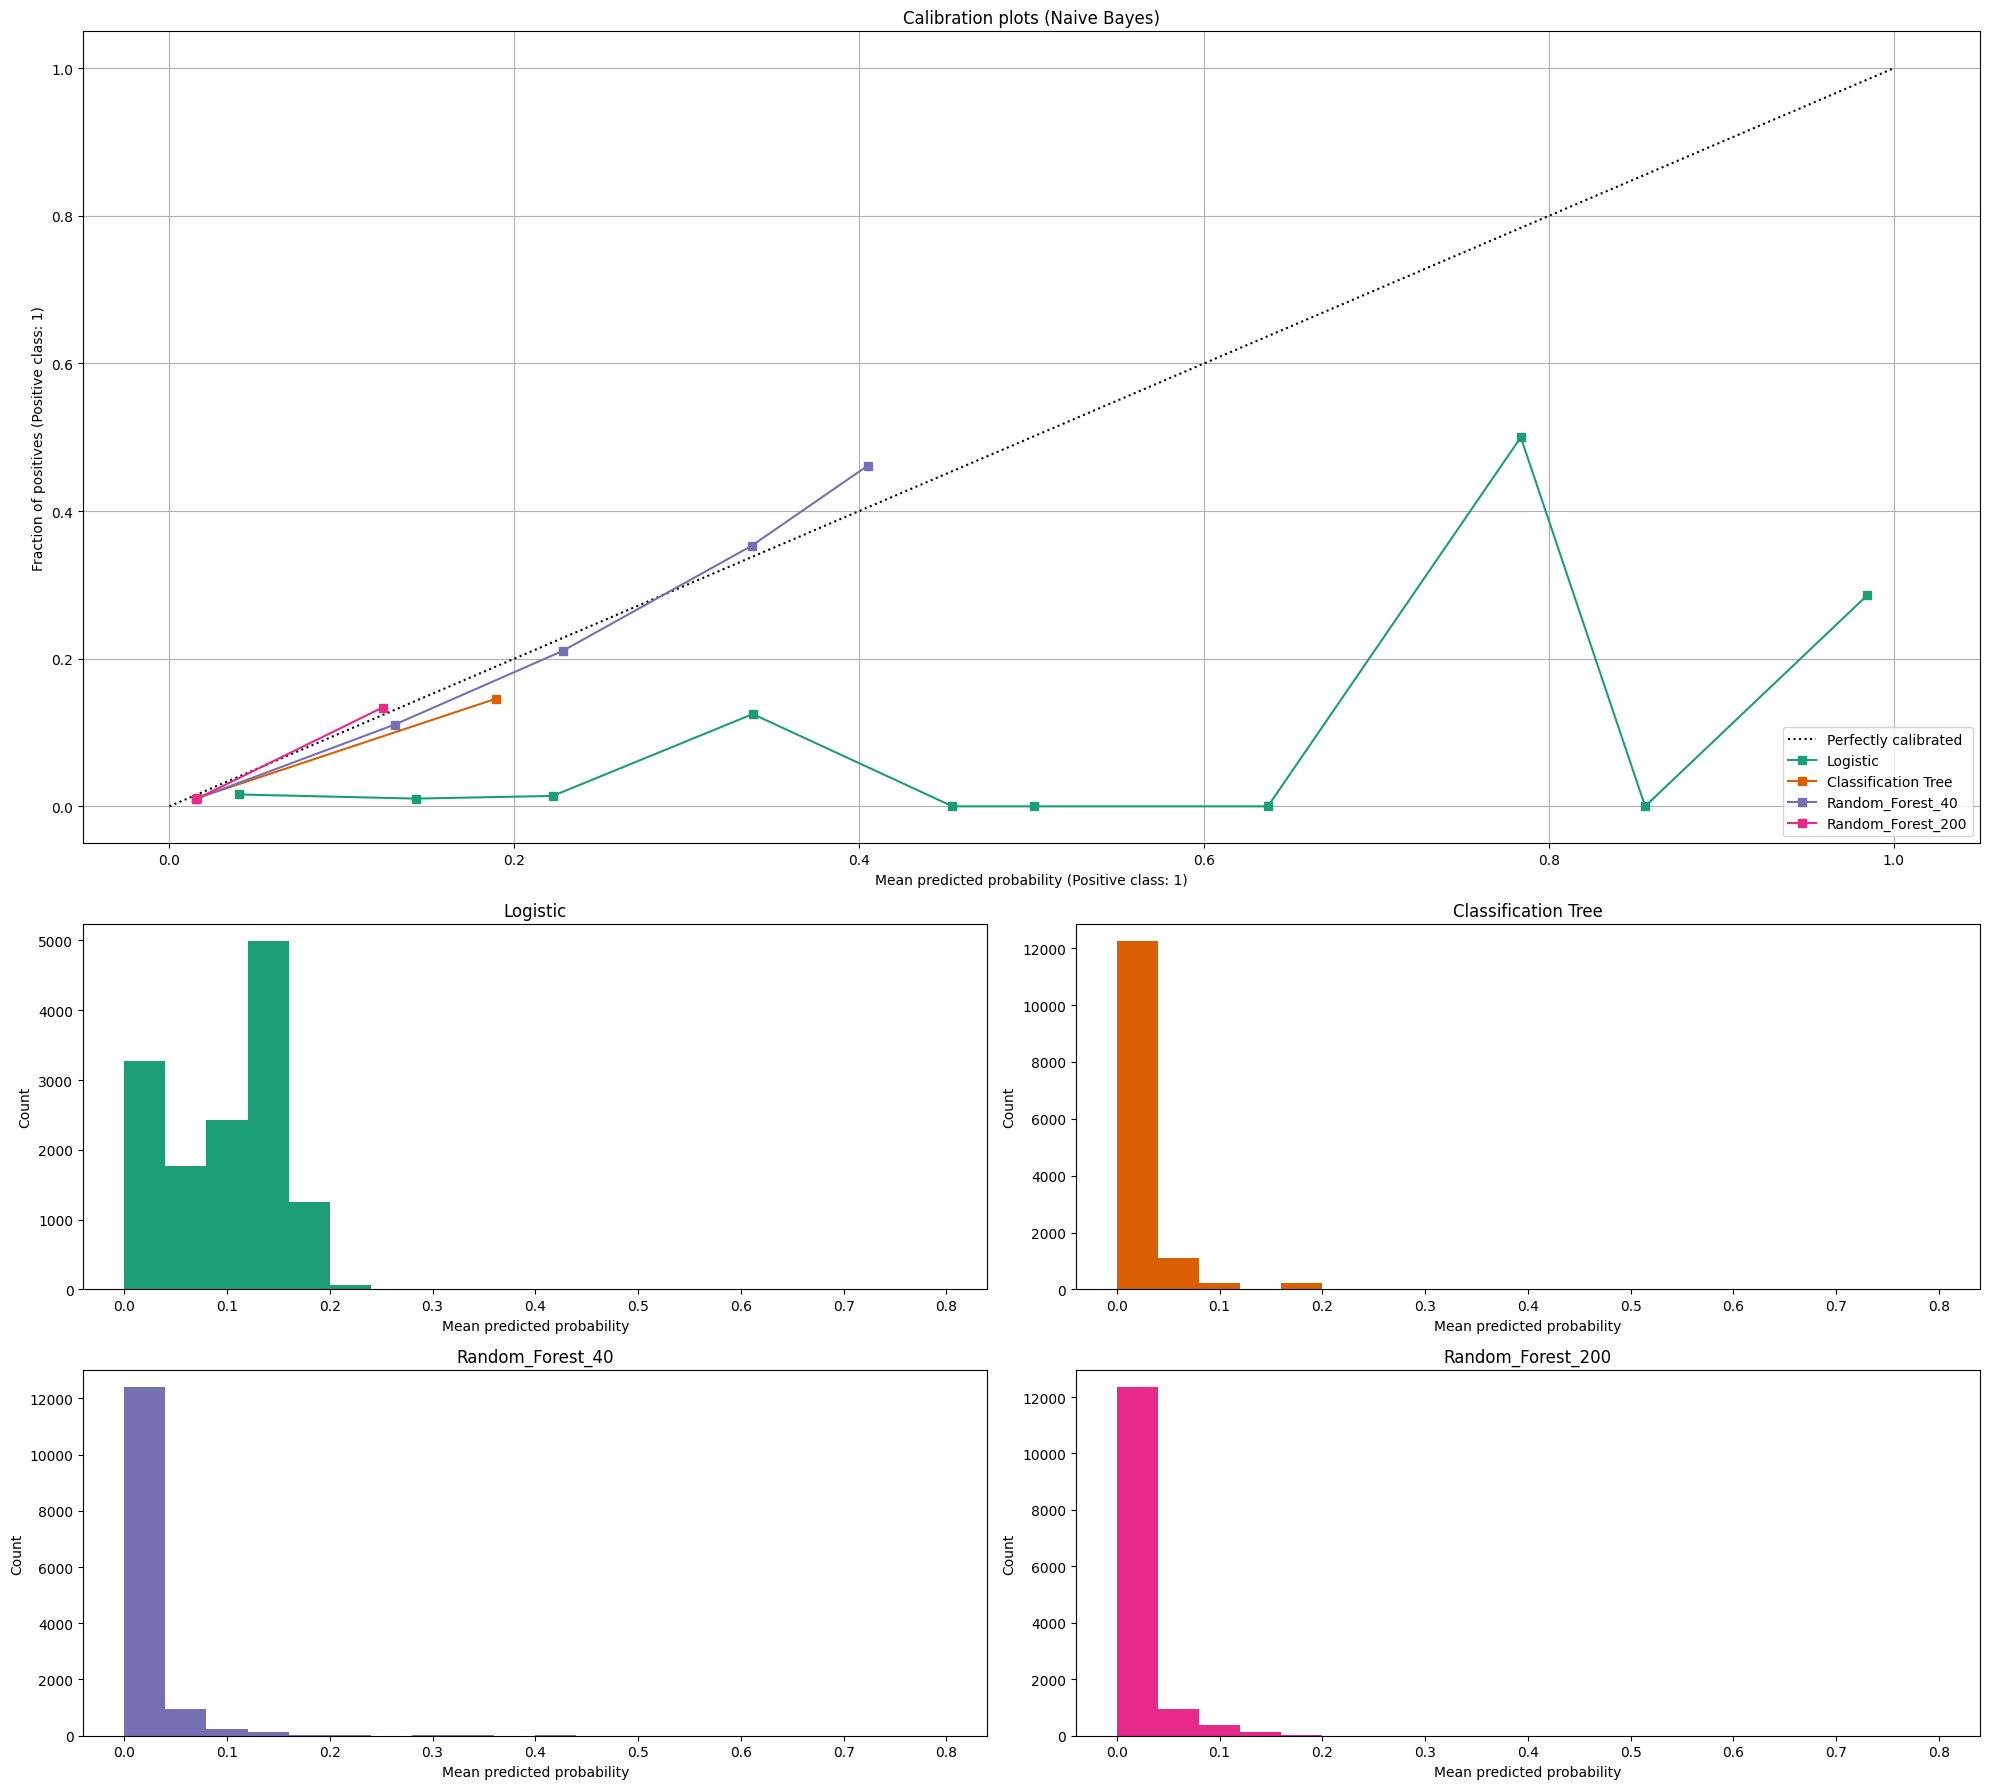

In [31]:
fig = plt.figure(figsize=(20, 18))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")
fitted_models = {}

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}

for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    fitted_models[name] = clf

    display = CalibrationDisplay.from_estimator(
        clf,
        X_test,
        y_test,
        n_bins = 10,
        name = name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(clf_list):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 0.8),
        bins=20,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

# I want to add more details to the plot 

plt.tight_layout()
plt.show()

In [57]:
Random_Forest_1.fit(X_train[cols], y_train)
predictions = Random_Forest_1.predict(X_test[cols])
prob_predictions = Random_Forest_1.predict_proba(X_test[cols])
accuracy = accuracy_score(y_test, predictions)
prec = precision_score(y_test, predictions)


In [58]:
predictions
prob_predictions[:, 1].max()

0.5177635281705086

In [32]:
from collections import defaultdict

import pandas as pd

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

scores = defaultdict(list)
for i, (clf, name) in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_prob = clf.predict_proba(X_test)
    y_pred = clf.predict(X_test)
    scores["Classifier"].append(name)

    for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_prob[:, 1]))

    for metric in [precision_score, recall_score, f1_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y_test, y_pred))

    score_df = pd.DataFrame(scores).set_index("Classifier")
    score_df.round(decimals=3)

score_df

KeyboardInterrupt: 

In [60]:
X_test

,spent_to_date,max_payment,payments_to_date,user_matuirity,payments_last_7_days,spent_last_7_days,max_payment_in_day,std_payments
562473,127.98,29.99,14,43,0,0.0,83.98,33.139343
562474,127.98,29.99,14,42,0,0.0,83.98,33.139343
562475,127.98,29.99,14,41,0,0.0,83.98,33.139343
562476,127.98,29.99,14,40,0,0.0,83.98,33.139343
562477,127.98,29.99,14,39,0,0.0,83.98,33.139343
...,...,...,...,...,...,...,...,...
819021,10.00,10.00,1,15,0,0.0,10.00,0.000000
819022,5.00,5.00,1,15,0,0.0,5.00,0.000000
819023,31.00,5.00,8,15,0,0.0,19.00,4.949747
819024,40.00,10.00,6,15,1,5.0,15.00,5.773503


0.0
1.0



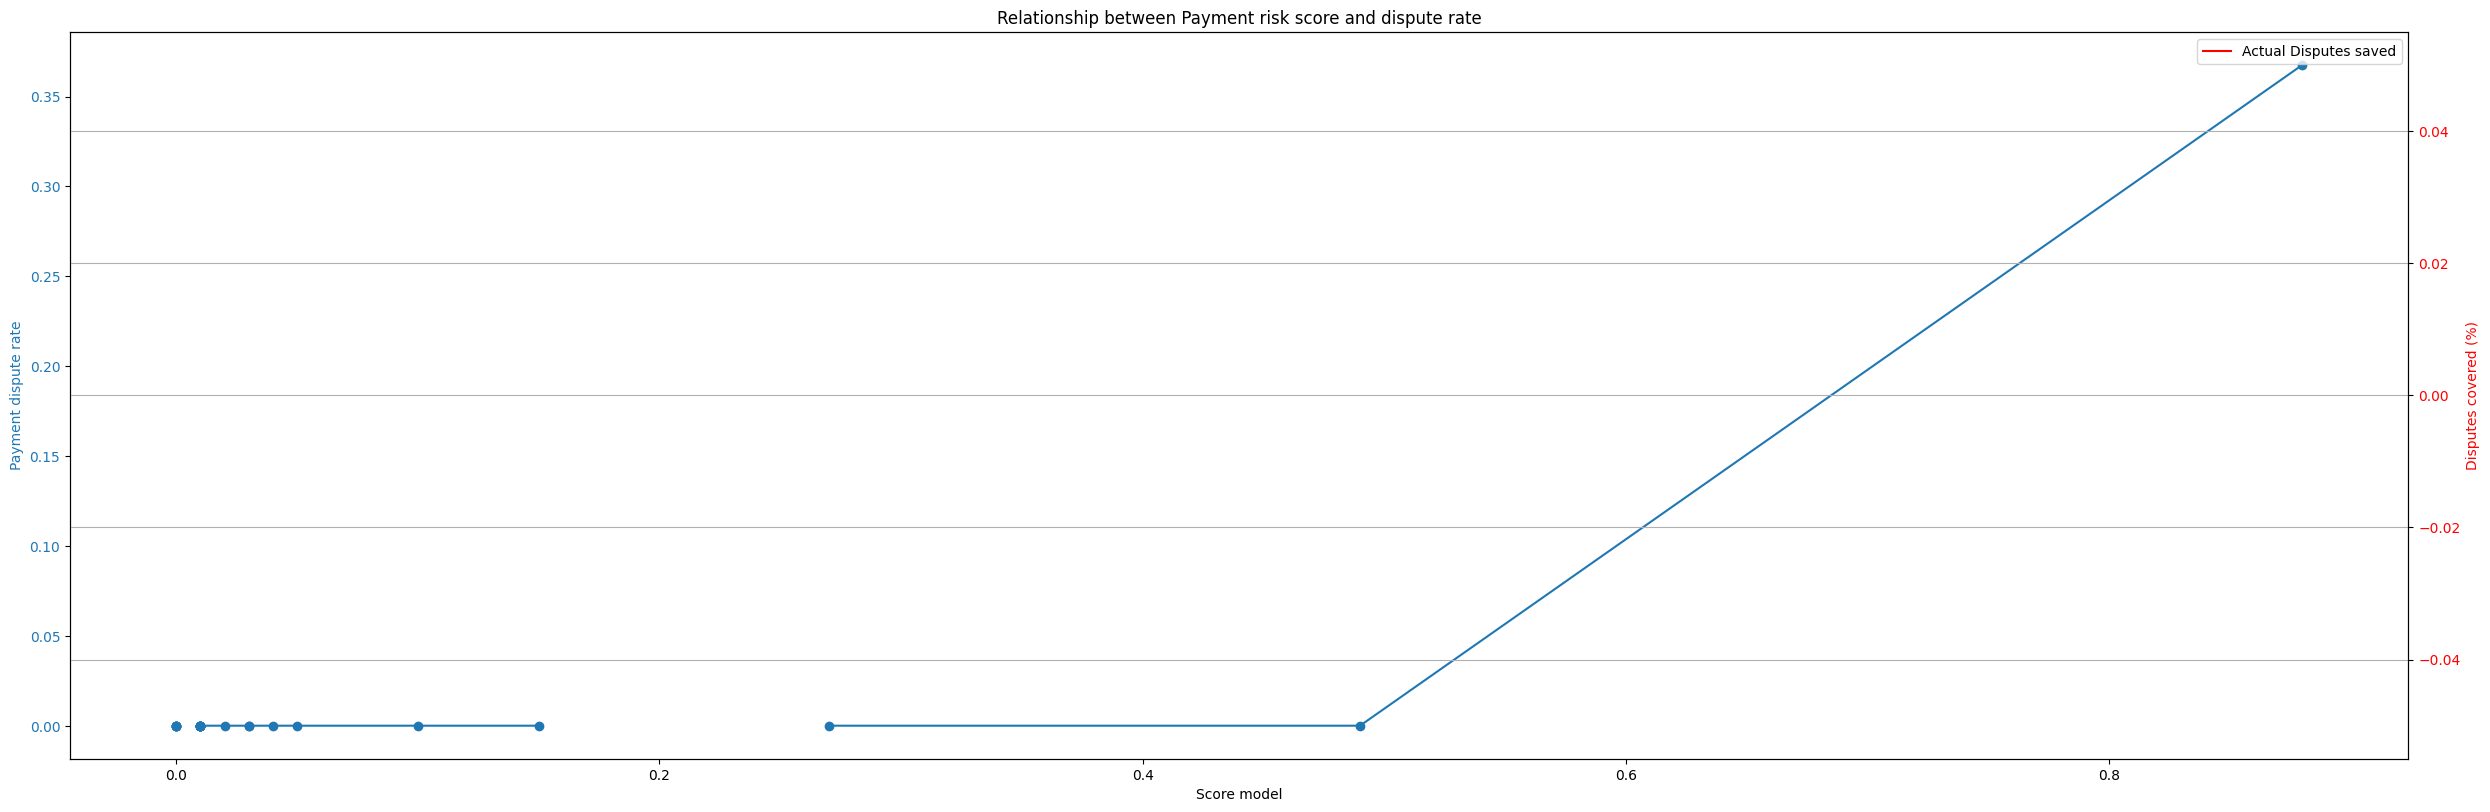

In [42]:
# Don't run
X_test_old = X_test.copy(deep = True)
X_test = X_test_old.copy(deep = True)

X_test['pred'] = Random_Forest.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run
print(X_test['pred'].min())
print(X_test['pred'].max())
print('')

# Calculate 200 equally sized groups
quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
percentiles = np.percentile(X_test['pred'], quantiles)

# Step 1: Calculate the quantiles of 'prob' column
quantiles = X_test['pred'].quantile([i/100 for i in range(1, 101)])

# # Step 2: Calculate the mean of 'is_dispute' for each quantile range
mean_values = []
for i in range(len(quantiles)):

    lower_quantile = quantiles.reset_index(drop = True)[i]

    if i < len(quantiles) - 1:
      upper_quantile = quantiles.reset_index(drop = True)[i + 1]
    else:
      upper_quantile = 100

    subset = X_test[(X_test['pred'] >= lower_quantile) & (X_test['pred'] < upper_quantile)]
    mean_dispute = subset['is_dispute'].mean()
    mean_values.append(mean_dispute)

# Create line plot
x_values = (np.concatenate((percentiles[1:], [lower_quantile]))).round(4)[:-1]
y_values = mean_values[:-1]

# Create a figure and axis for the first plot
fig, ax1 = plt.subplots(figsize = (25, 8))

# Plot the first line on the first Y-axis
color = 'tab:blue'
ax1.set_xlabel('Score model')
ax1.set_ylabel('Payment dispute rate', color=color)
ax1.plot((x_values * 100).round(2), y_values, marker = 'o', color=color)
ax1.tick_params(axis='y', labelcolor = color)

# Create a secondary Y-axis for the second plot
ax2 = ax1.twinx()

quantiles = np.linspace(0, 100, 101)[:-1]  # Generate 200 equally spaced percentiles

# Calculate the actual percentiles
quantiles = np.percentile(X_test['pred'], quantiles)

# Step 2: Calculate average of 'id_dispute' for each quantile
average_id_dispute = []
for quantile in quantiles:
    avg_id_dispute = X_test[X_test['pred'] <= quantile]['is_dispute'].sum()
    average_id_dispute.append(avg_id_dispute)

# Step 3: Create line plot
x_values = (np.concatenate((quantiles[1:], [lower_quantile]))*100).round(2)[:-1]
y_values = 1 - (average_id_dispute/(average_id_dispute[-1]))[:-1]
ax2.plot(x_values, y_values, label = 'Actual Disputes saved', color = 'red')
ax2.set_ylabel('Disputes covered (%)', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Add legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc = 0)
del X_test['pred']
del X_test['is_dispute']

fig.tight_layout()
plt.title('Relationship between Payment risk score and dispute rate')
plt.grid(True)
plt.show()


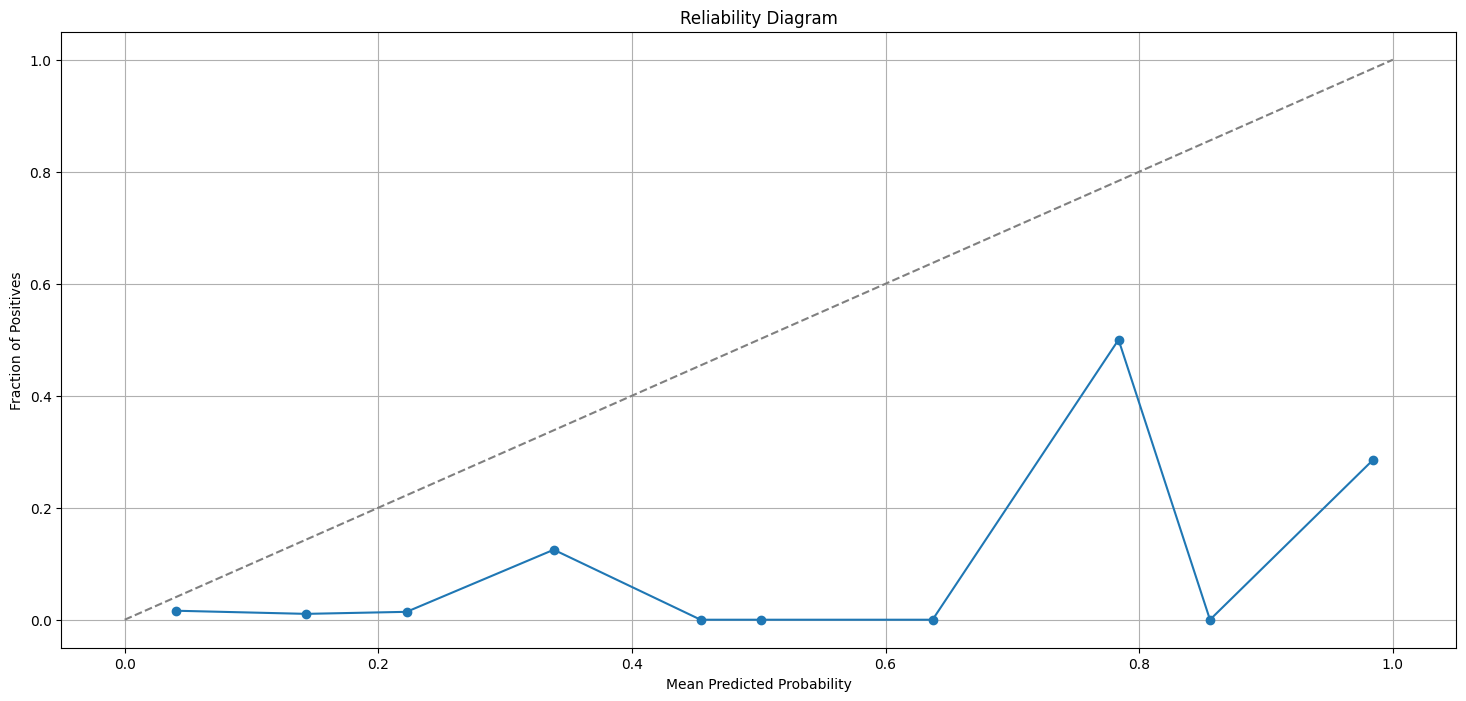

In [33]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

X_test['pred'] = lr.predict_proba(X_test[cols])[:, 1] # deleted after run
X_test['is_dispute'] = y_test # deleted after run

# Compute calibration curve
prob_true, prob_pred = calibration_curve(X_test['is_dispute'], X_test['pred'] , n_bins=10, strategy='uniform')

# Plot reliability diagram
plt.figure(figsize=(18, 8))
plt.plot(prob_pred, prob_true, marker='o', linestyle='-')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Diagonal line for perfect calibration
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram')
plt.grid(True)
plt.show()


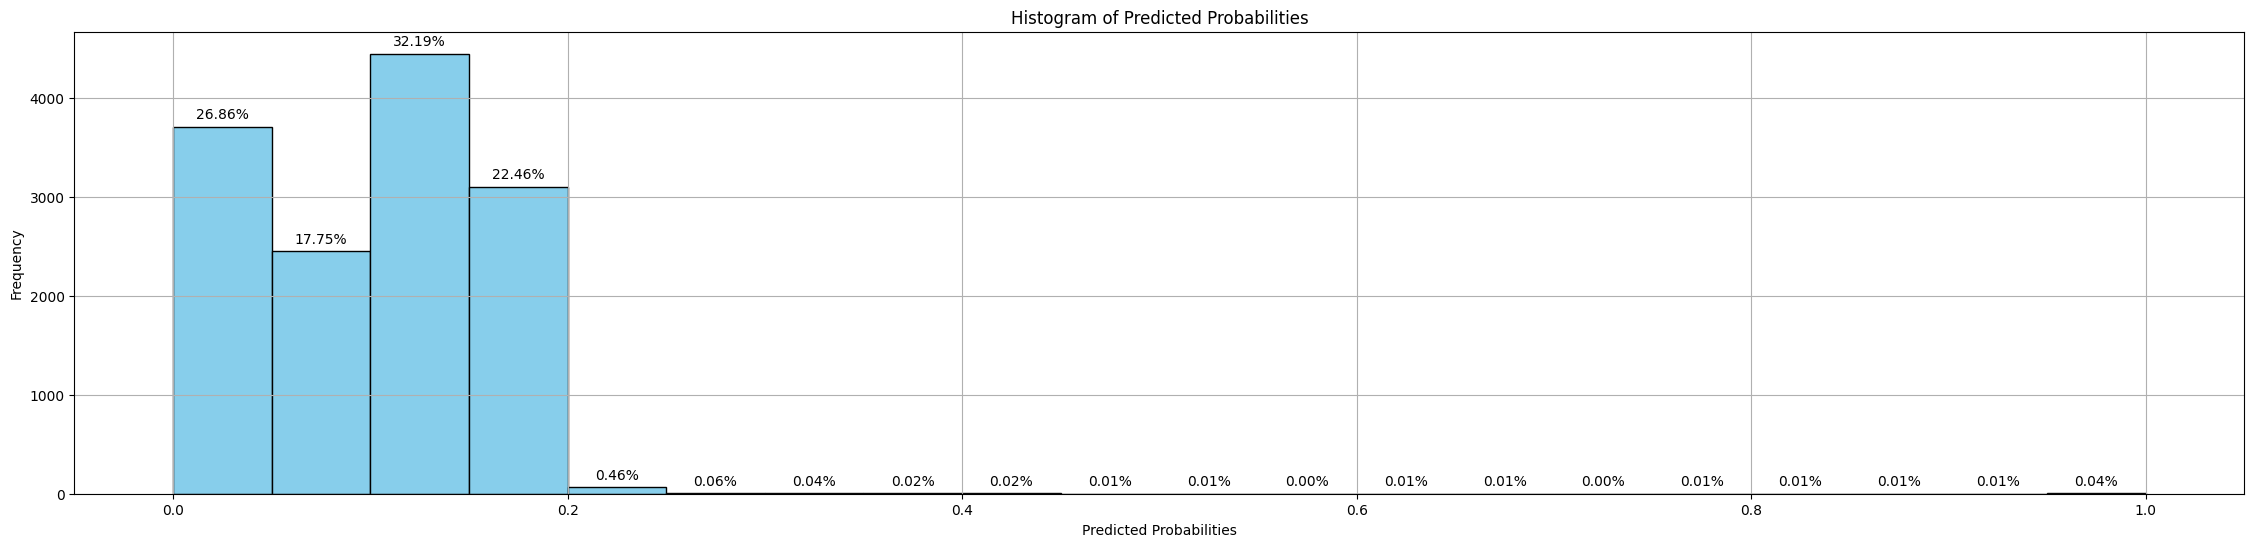

In [34]:
import matplotlib.pyplot as plt

# Assuming X_test['pred'] contains the predicted probabilities
pred_probabilities = X_test['pred']

# Plot histogram
plt.figure(figsize=(28, 6))
n, bins, patches = plt.hist(pred_probabilities, bins=20, color='skyblue', edgecolor='black')

# Compute percentages for each bin
bin_percentages = [(count / len(pred_probabilities)) * 100 for count in n]

# Add labels to bars
for patch, percentage in zip(patches, bin_percentages):
    height = patch.get_height()
    plt.text(patch.get_x() + patch.get_width() / 2, height + 50, f'{percentage:.2f}%', ha='center', va='bottom')

plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.grid(True)
plt.show()


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = make_classification(
    n_samples=1_000,
    n_features=2,
    n_redundant=0,
    n_informative=2,
    random_state=1,
    n_clusters_per_class=1,
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
classifiers = {
    "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025)),
    # "Linear SVM": make_pipeline(StandardScaler(), LinearSVC(C=0.025, dual="int")),
    "Random Forest": RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1
    ),
}

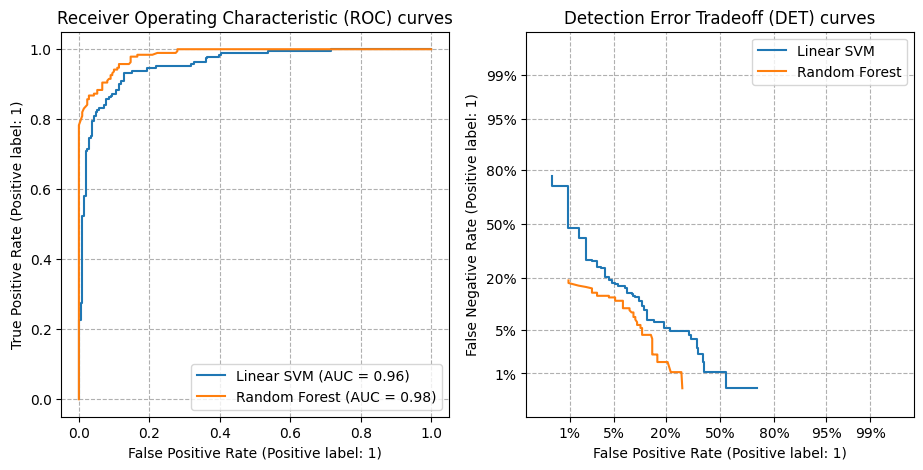

In [11]:
import matplotlib.pyplot as plt

from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)

    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_roc, name=name)
    DetCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax_det, name=name)

ax_roc.set_title("Receiver Operating Characteristic (ROC) curves")
ax_det.set_title("Detection Error Tradeoff (DET) curves")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

plt.legend()
plt.show()

# Real Cross-Validation 

This part I want to implement a piece of code that breaks the training into multiple parts. Then it predicts and allocates probabilities. Subsequently it generates a visual and reports the metrics that I need to make decisions. 

For example, I want to see the number of users over time. So, I need to do the following: 

1. Break the dataset 
2. Do a model without one piece and calcualte the predictions and the actuals - You can save this 
3. Return the desired metrics - You can save this 
4. plot the results - You can save this 
5. Calcualte the overall metrics. For example, you can calculate the mean metric, and you can plot all the sampled data. 


### Break the dataset 

In [51]:
# result = result[result['user_matuirity'] == 15].reset_index(drop = False)
# result

In [52]:
validation_sets = 4
# result['date'] = pd.to_datetime(result['register_time_x']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))
result['validation_set_id'] = pd.qcut(result['date'].values, validation_sets)
# result['validation_set_id'] = 1
result.groupby('validation_set_id').size()

validation_set_id
(20231001.999, 20231210.0]    9782
(20231210.0, 20231226.0]      9943
(20231226.0, 20240109.0]      9392
(20240109.0, 20240122.0]      9358
dtype: int64

In [53]:
result.groupby('validation_set_id')['disputer'].mean()


validation_set_id
(20231001.999, 20231210.0]    0.006236
(20231210.0, 20231226.0]      0.005934
(20231226.0, 20240109.0]      0.004685
(20240109.0, 20240122.0]      0.003206
Name: disputer, dtype: float64

Warning: The plot belows shows that there is a problem with the data utilised. Overall I think we're considereing to late users and too later payments to obtain dispute rates

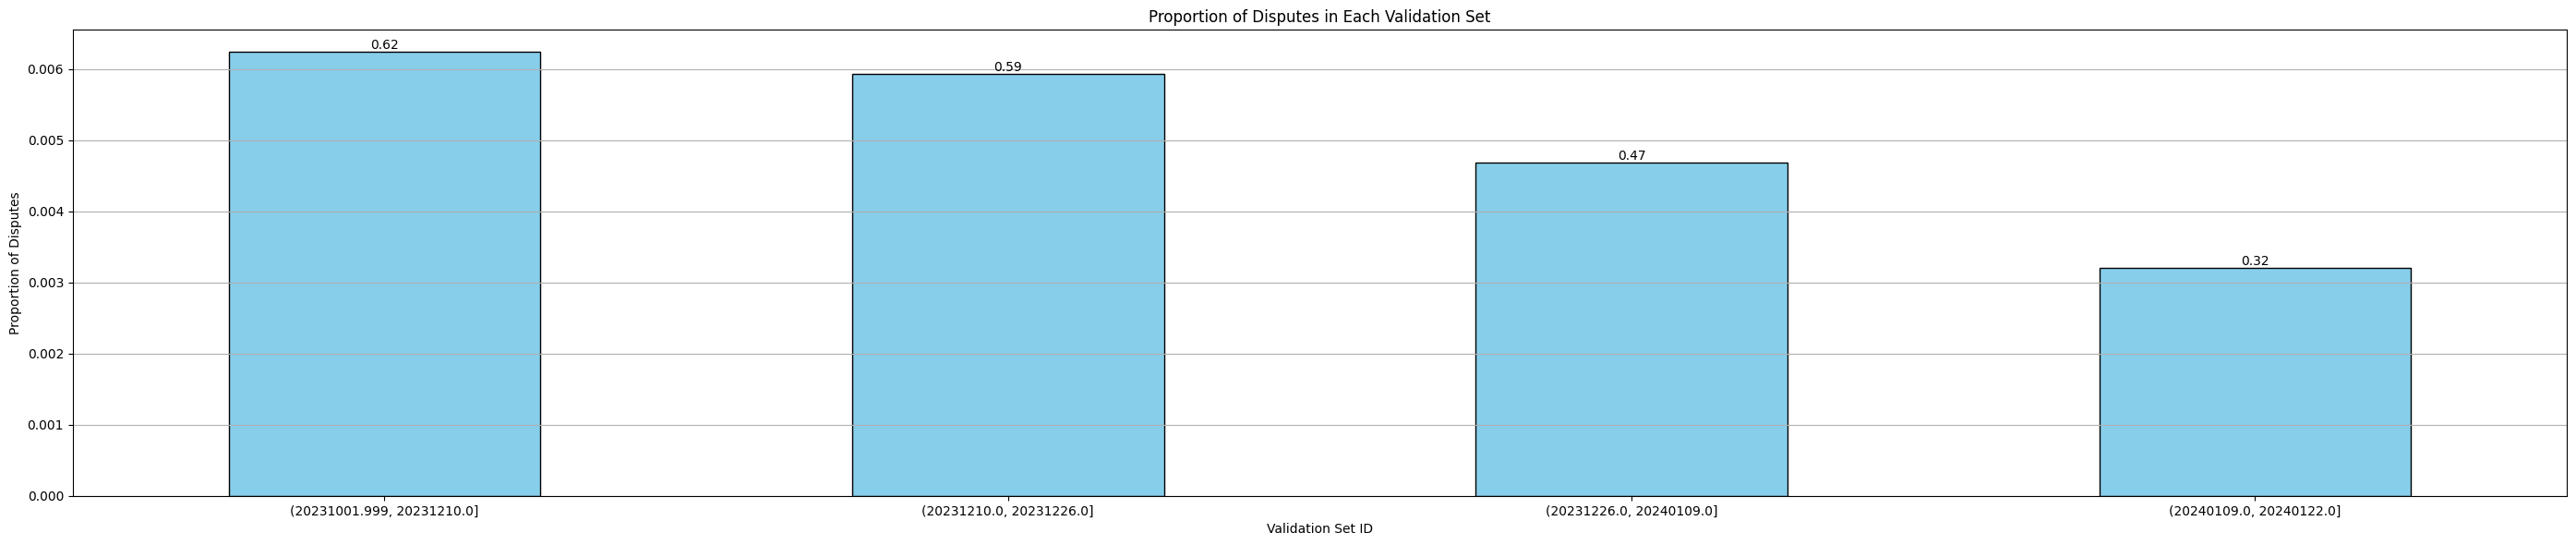

In [54]:
# validation_sets = 3

# # Convert register_time_x to datetime
# result['date'] = pd.to_datetime(result['register_time']).apply(lambda x: int(x.strftime('%Y%m%d')))

# # Create validation_set_id based on quantiles
# result['validation_set_id'] = pd.qcut(result['date'], validation_sets)

# Calculate the proportion of disputes in each group
proportion_disputes = result.groupby('validation_set_id')['disputer'].mean()

# Plot
plt.figure(figsize=(28, 6))
proportion_disputes.plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Validation Set ID')
plt.ylabel('Proportion of Disputes')
plt.title('Proportion of Disputes in Each Validation Set')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines only on the y-axis
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Add value labels on top of bars
for i, value in enumerate(proportion_disputes):
    plt.text(i, value, f'{value*100:.2f}', ha='center', va='bottom')

plt.show()


In [55]:
result[payment_cols]

,spent_to_date,max_payment,payments_last_14d,payments_last_7d,games_last_14d,games_last_7d,games_to_date,payments_to_date,spent_last_14d,spent_last_7d,max_daily_spent,daily_pay_std,money_games_to_date,disputer
0,5.00,5.00,0,0,0.0,0.0,235.0,1,0.00,0.00,5.00,1.066004,170.0,0
1,101.00,86.00,0,0,0.0,0.0,651.0,3,0.00,0.00,86.00,18.357678,178.0,0
2,10.00,2.00,0,0,0.0,0.0,1499.0,5,0.00,0.00,10.00,0.426401,941.0,0
3,1.00,1.00,1,0,2073.0,1459.0,2221.0,1,1.00,0.00,1.00,0.213201,437.0,0
4,7.00,7.00,0,0,0.0,0.0,120.0,1,0.00,0.00,7.00,1.492405,45.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38470,3.00,3.00,0,0,0.0,0.0,73.0,1,0.00,0.00,3.00,0.639602,48.0,0
38471,17.00,10.00,0,0,0.0,0.0,946.0,2,0.00,0.00,17.00,2.132007,866.0,0
38472,3.00,3.00,0,0,0.0,0.0,347.0,1,0.00,0.00,3.00,0.639602,176.0,0
38473,1.00,1.00,1,0,806.0,61.0,3339.0,1,1.00,0.00,1.00,0.213201,2697.0,0


In [57]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

estimators = [
     ('rf', RandomForestClassifier(min_samples_leaf=6, random_state=42)),
     ('rf_2', RandomForestClassifier(min_samples_leaf=30, random_state=42))]

stck = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5), passthrough = True
)


models = {
    'RandomForest_20':            RandomForestClassifier(min_samples_leaf = 20, n_jobs = 5)
    # , 'RandomForest_10':         Ran   domForestClassifier(min_samples_leaf = 6, n_jobs = 5)
    , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 5, n_jobs = 5)
    # , 'RandomForest_400':         RandomForestClassifier(min_samples_leaf = 100, n_jobs = 5)
    , 'LogisticRegression':       LogisticRegressionCV(max_iter = 100, l1_ratios = np.logspace(0, 1, 4), cv = 2, n_jobs = 5)
    , 'Stacking':                 stck  # Need to set probability=True for SVC to use predict_proba
    # , 'DecisionTree_350':       DecisionTreeClassifier(min_samples_leaf = 350)
    # , 'DecisionTree_400':       DecisionTreeClassifier(min_samples_leaf = 400)
    , 'DecisionTree_100':         DecisionTreeClassifier(min_samples_leaf = 100)
}

# class_weight
# lr                = LogisticRegression(C = 1.0, max_iter = 180, n_jobs = 5)
# lr                = LogisticRegressionCV(max_iter = 140, l1_ratios = np.logspace(0, 1, 10), cv = 2, n_jobs = 5)
# Random_Forest_40  = RandomForestClassifier(min_samples_leaf = 40, n_jobs = 5)
# Random_Forest_200 = RandomForestClassifier(min_samples_leaf = 200, n_jobs = 5)
# dt                = DecisionTreeClassifier(min_samples_leaf = 350)

# models = [
#     (lr, "Logistic")
#     , (dt, "Classification Tree")
#     , (Random_Forest_40, "Random_Forest_40")
#     , (Random_Forest_200, "Random_Forest_200")
# ]

# Create an empty list to store results
training_results = []

# Loop through each validation set
for validation_set in tqdm(result['validation_set_id'].unique()): 

    # Remove it: 
    train_data = result[result['validation_set_id'] != validation_set][cols + ['disputer']]
    test_data  = result[result['validation_set_id'] == validation_set][cols + ['disputer']]

    # Train and predict with each model
    for model_name, model in models.items():
        X_train, y_train = train_data.drop(columns=['disputer']), train_data['disputer']
        X_test, y_test = test_data.drop(columns=['disputer']), test_data['disputer']
        model.fit(X_train[cols], y_train)
        prob_predictions = model.predict_proba(X_test[cols])[:, 1]

        # Store the predictions along with validation set and model name
        training_results.append(pd.DataFrame({
            'Validation_Set': [validation_set] * len(prob_predictions),
            f'{model_name}_Probability_Predictions': prob_predictions,
            'Actual_Labels': y_test
        }))

# Concatenate all DataFrames into one
training_results = pd.concat(training_results, ignore_index=True)
training_results


100%|██████████| 4/4 [03:31<00:00, 52.99s/it]


,Validation_Set,RandomForest_20_Probability_Predictions,Actual_Labels,RandomForest_400_Probability_Predictions,LogisticRegression_Probability_Predictions,Stacking_Probability_Predictions,DecisionTree_100_Probability_Predictions
0,"(20231001.999, 20231210.0]",0.000014,0,NaN,NaN,NaN,NaN
1,"(20231001.999, 20231210.0]",0.002777,0,NaN,NaN,NaN,NaN
2,"(20231001.999, 20231210.0]",0.005810,0,NaN,NaN,NaN,NaN
3,"(20231001.999, 20231210.0]",0.000000,0,NaN,NaN,NaN,NaN
4,"(20231001.999, 20231210.0]",0.009297,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
192370,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192371,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192372,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0
192373,"(20240109.0, 20240122.0]",NaN,0,NaN,NaN,NaN,0.0


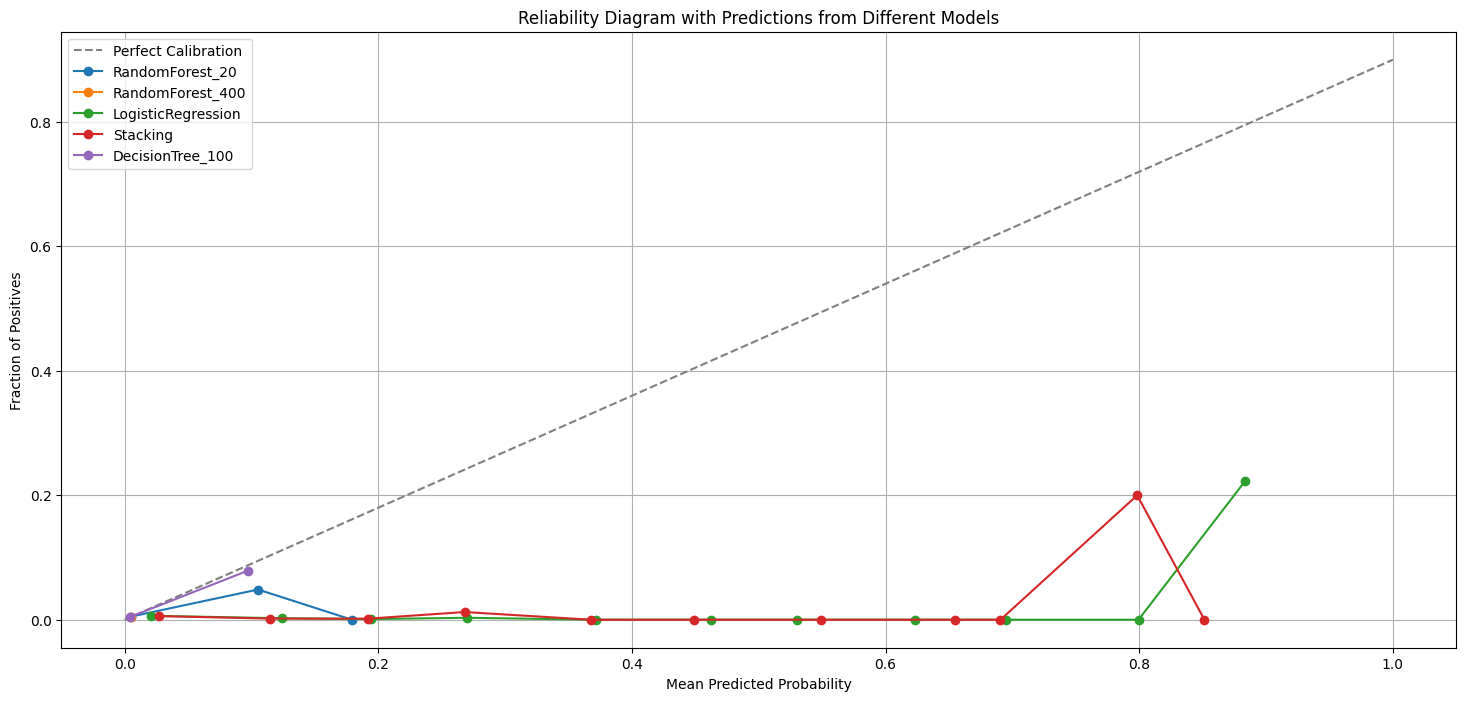

In [58]:

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Compute calibration curve for each model
plt.figure(figsize=(18, 8))
plt.plot([0, 1], [0, 0.9], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    model_actual_labels = training_results['Actual_Labels']
    
    # Compute calibration curve
    prob_true, prob_pred = calibration_curve(model_actual_labels, model_predictions, n_bins=12, strategy='uniform')

    # Plot reliability diagram for the current model
    plt.plot(prob_pred, prob_true, marker='o', linestyle='-', label=model_name)

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [59]:
models.keys()

dict_keys(['RandomForest_20', 'RandomForest_400', 'LogisticRegression', 'Stacking', 'DecisionTree_100'])

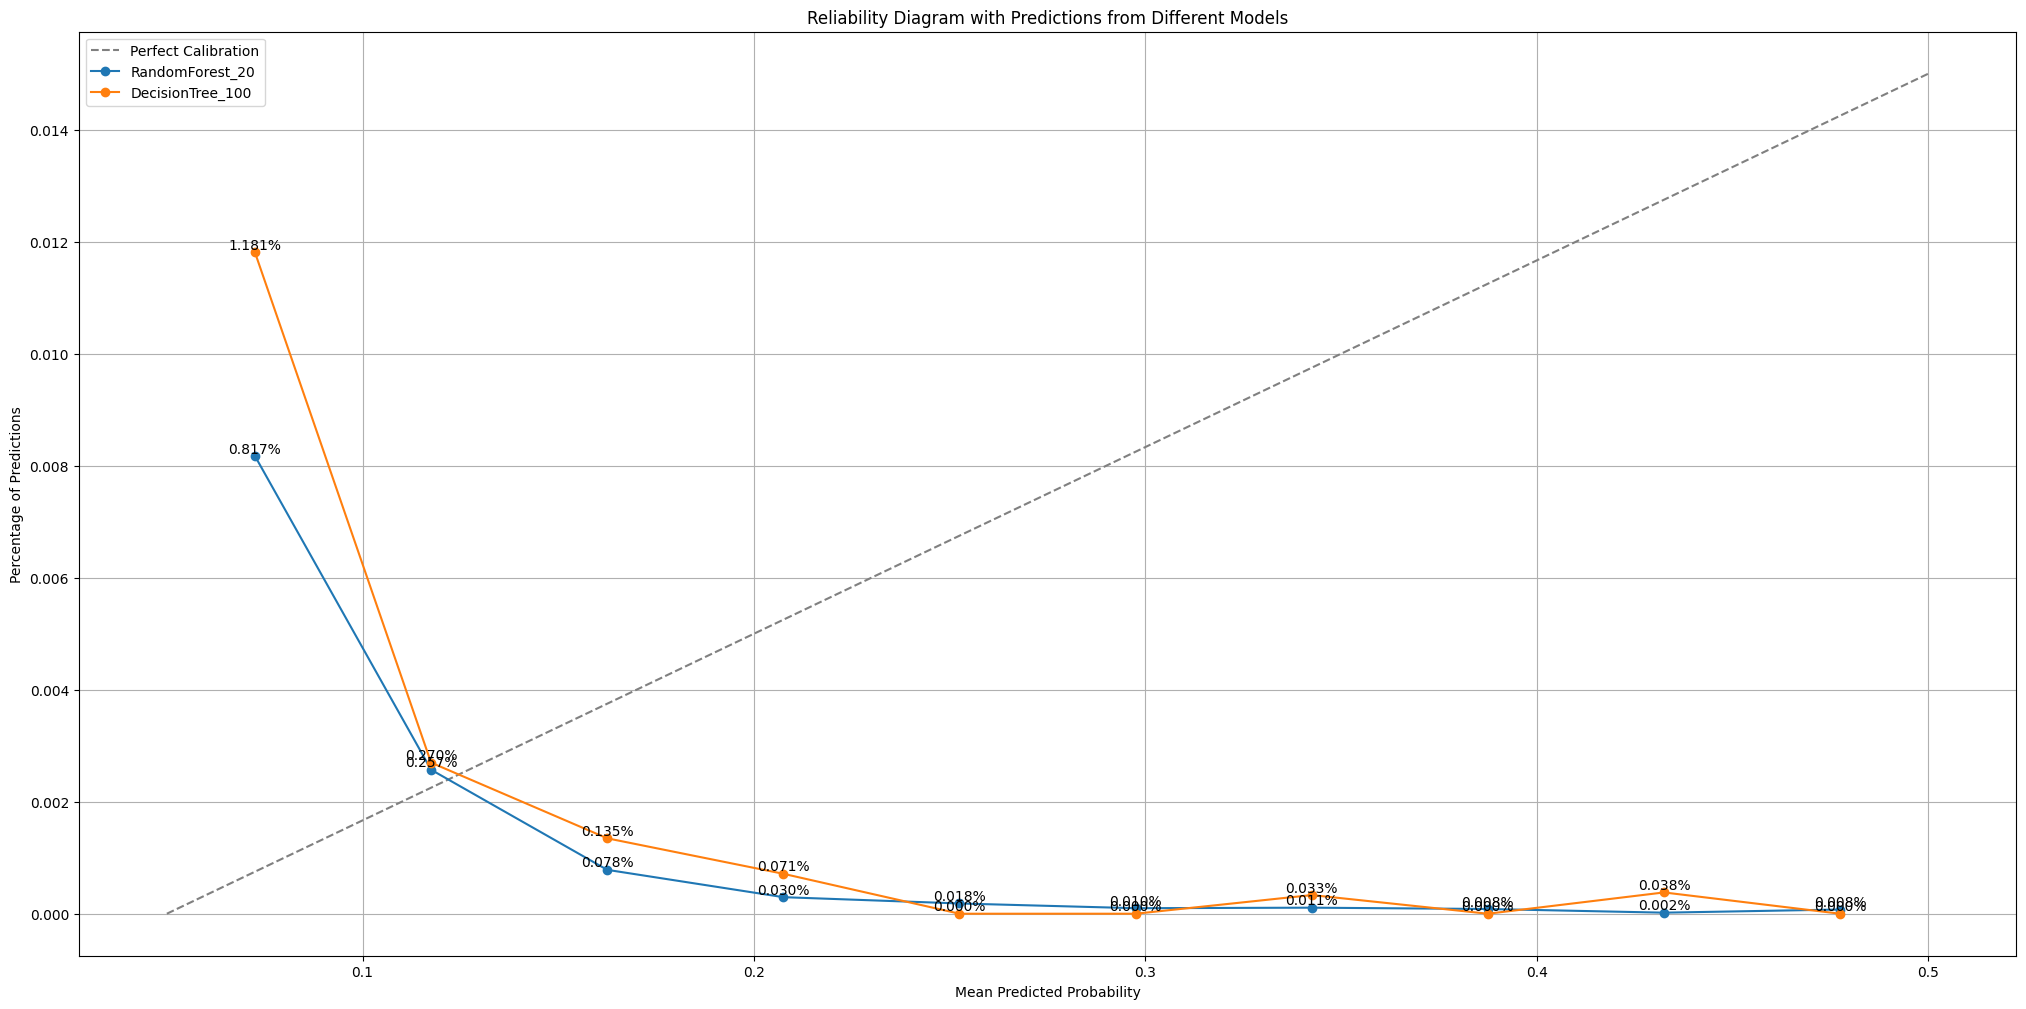

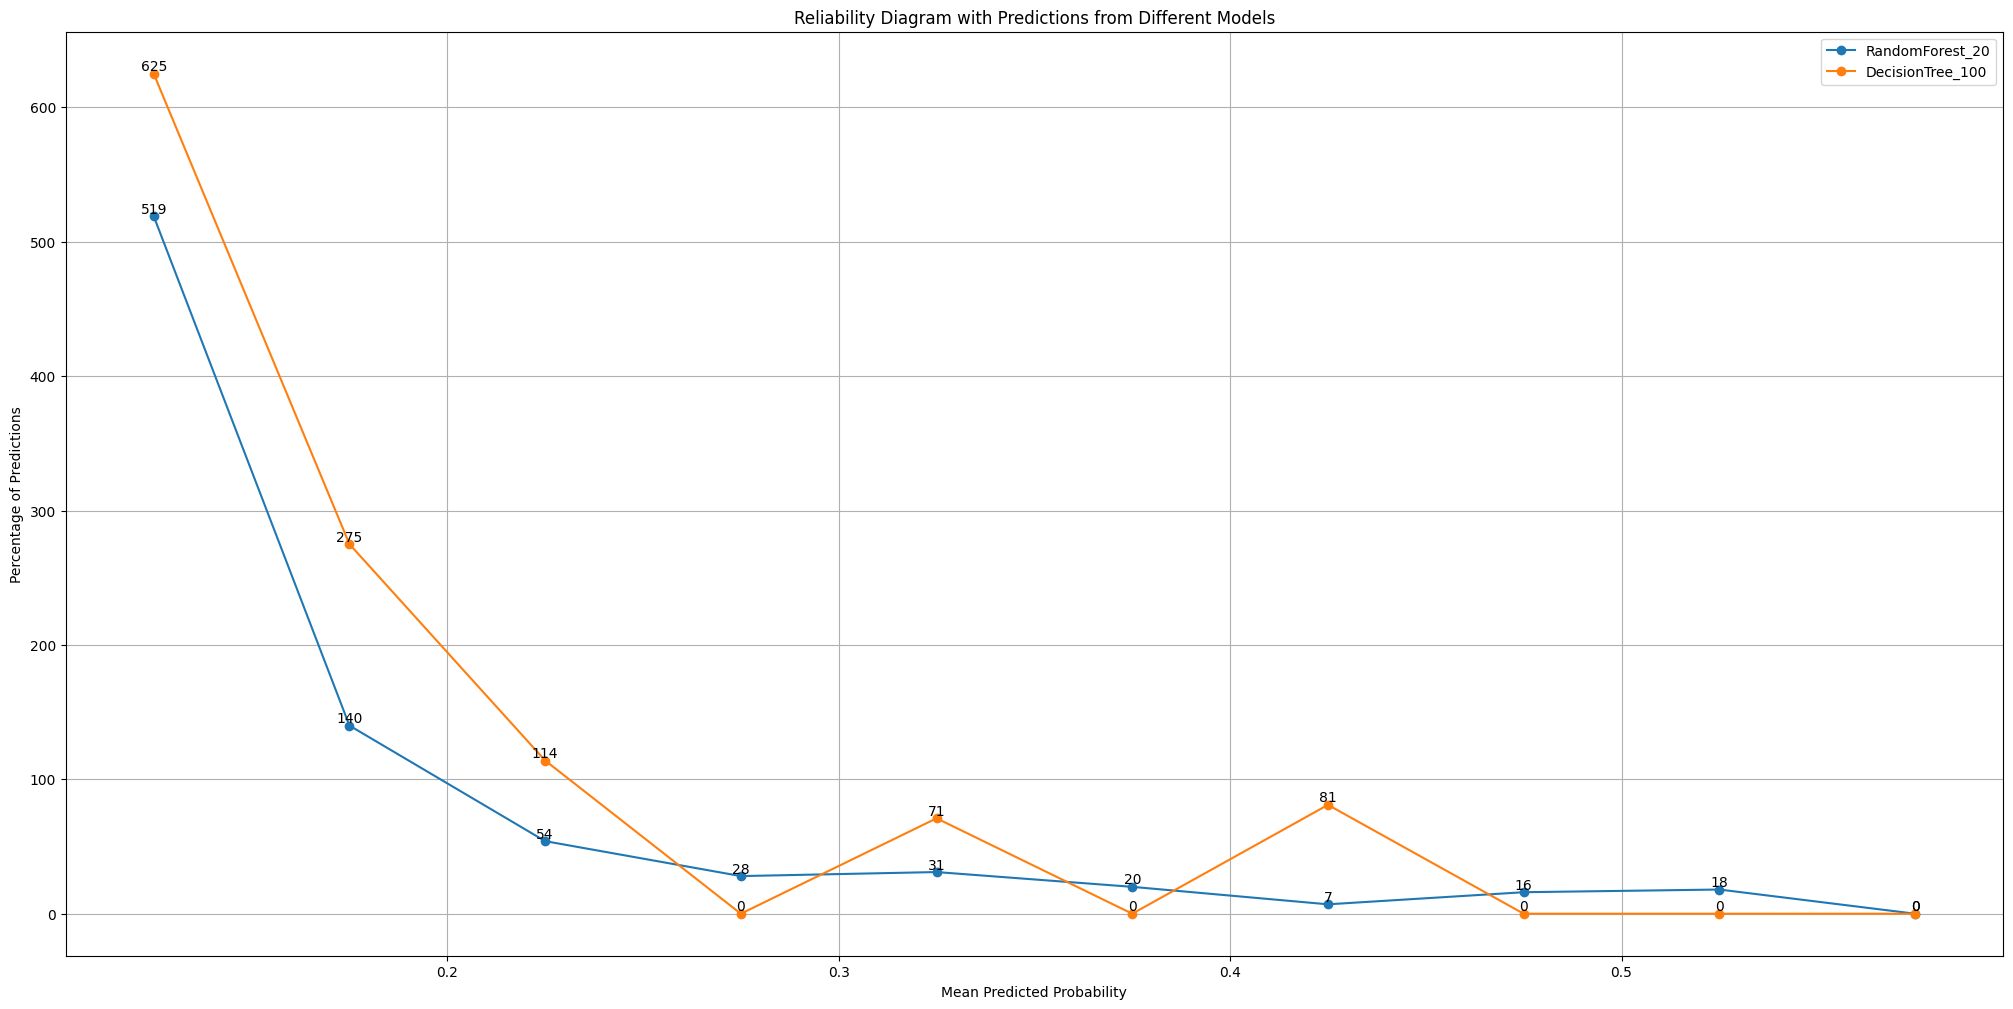

In [50]:
import numpy as np

# Compute calibration curve for each model
plt.figure(figsize=(25, 12))
plt.plot([0.05, 0.5], [0, 0.015], linestyle='--', color='gray', label='Perfect Calibration')  # Diagonal line for perfect calibration

# for model_name in models.keys():
for model_name in ['RandomForest_20', 'DecisionTree_100']:
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.05, 0.5))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts / len(model_predictions)
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]*100:.3f}%', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(25, 12))

for model_name in ['RandomForest_20', 'DecisionTree_100']:
# for model_name in models.keys():
    # Extract predictions for the current model
    model_predictions = training_results[f'{model_name}_Probability_Predictions']
    
    # Compute histogram of predicted probabilities
    counts, bins = np.histogram(model_predictions, bins=10, range=(0.1, 0.6))
    bin_centers = (bins[:-1] + bins[1:]) / 2
    
    # Compute percentage of predictions in each bin
    percentages = counts
    
    # Plot reliability diagram for the current model
    plt.plot(bin_centers, percentages,  marker='o', linestyle='-', label=model_name)

    # Add labels to the histogram bars
    for i in range(len(bin_centers)):
        plt.text(bin_centers[i], percentages[i], f'{percentages[i]}', ha='center', va='bottom')

plt.xlabel('Mean Predicted Probability')
plt.ylabel('Percentage of Predictions')
plt.title('Reliability Diagram with Predictions from Different Models')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

#check ensembles: 
training_results['best_two'] = training_results['RandomForest_Probability_Predictions'] + training_results['SVC_Probability_Predictions'].fillna(0)

In [ ]:
from tqdm import tqdm, tqdm_notebook
from sklearn.metrics import accuracy_score, precision_score


model_results = []
all_model_results = []
criteria = ['gini', 'entropy', 'log_loss']
depths = [4,5,6, 7]
leaf_sizes = [200]
cols = ['valid_payments', 'p3', 'p7', 'p14', 'p28']
payment_cols = cols + ['disputer']
# for train_index, test_index in splits:
for date_group in result['validation_set_id'].unique():

    train_data =  result[result['validation_set_id'] != date_group][payment_cols]
    test_data =  result[result['validation_set_id'] == date_group][payment_cols]

    # Separate features (X) and target variable (y)
    X_train, y_train = train_data.drop(columns = [f'disputer']), train_data[f'disputer']
    X_test, y_test = test_data.drop(columns = [f'disputer']), test_data[f'disputer']

    # old_cols = X_train.copy().columns
    # X_train = all_feature_enginerring(X_train, y_train)
    # X_test = all_feature_enginerring(X_test, y_test)

    for criterion in tqdm(criteria):

        for depth in depths:

            for leaf_size in leaf_sizes:

              model = create_model(criterion, depth, leaf_size, cols)

              model.fit(X_train[cols], y_train)
              predictions = model.predict(X_test[cols])
              accuracy = accuracy_score(y_test, predictions)
              prec = precision_score(y_test, predictions)
              

              # try:
              #     model.fit(X_train[cols], y_train)
              #     predictions = model.predict(X_test[cols])
              #     accuracy = accuracy_score(y_test, predictions)
              #     prec = precision_score(y_test, predictions)

              # except:
              #     model = np.nan
              #     predictions = np.nan
              #     mae = np.nan
              #     r2 = np.nan

              # Save the model into dictionary (Response, day, mo...)
              model_result = pd.DataFrame({
                  'Iteration': [str(criterion) + ' - ' + str(depth) + ' - ' + str(leaf_size)]
                  , 'Test at': [date_group]
                  , 'Model': [model]
                  , 'accuracy': [accuracy]
                  , 'precission': [prec]
                  # , 'rel_mae': [(((y_test - y_test.mean()).abs()).mean() - mae) / (((y_test - y_test.mean()).abs()).mean())]
              })

              model_results.append(model_result)

    all_model_results.extend(model_results)

all_model_results = pd.concat(all_model_results, ignore_index = True)#.sort_values(by = ['Available day', 'Model'])